<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/MLMatSci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/MachineLearning/Jupyter-notebooks/merged.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML for Material Scientists in python

In this notebook, you will use a set of different ML tools.
If you require more information about how to use Jupyter notebooks, you can consult:
* The main README file inside this repository: https://github.com/anthony-wang/BestPractices/blob/master/README.md
* The official Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/stable/notebook.html


To read the main publication for which these notebooks are made, please see:

Wang, Anthony Yu-Tung; Murdock, Ryan J.; Kauwe, Steven K.; Oliynyk, Anton O.; Gurlo, Aleksander; Brgoch, Jakoah; Persson, Kristin A.; Sparks, Taylor D., [Machine Learning for Materials Scientists: An Introductory Guide toward Best Practices](https://doi.org/10.1021/acs.chemmater.0c01907), *Chemistry of Materials* **Just Accepted Manuscript**, 2020. DOI: [10.1021/acs.chemmater.0c01907](https://doi.org/10.1021/acs.chemmater.0c01907)

Please also consider citing the work if you choose to adopt or adapt the methods and concepts shown in these notebooks or in the publication:

```bibtex
@article{Wang2020bestpractices,
    author = {Wang, Anthony Yu-Tung and Murdock, Ryan J. and Kauwe, Steven K. and Oliynyk, Anton O. and Gurlo, Aleksander and Brgoch, Jakoah and Persson, Kristin A. and Sparks, Taylor D.},
    date = {2020},
    title = {Machine Learning for Materials Scientists: An Introductory Guide toward Best Practices},
    issn = {0897-4756},
    journal = {Chemistry of Materials},
    url = {https://doi.org/10.1021/acs.chemmater.0c01907},
    doi = {10.1021/acs.chemmater.0c01907}
}
```

# Overview of Notebook

These notebooks are included to illustrate a hypothetical Machine Learning project created following best practices.

The goal of this ML project is to predict the heat capacity of inorganic materials given the chemical composition and condition (the measurement temperature).
We will use both classical ML models as well as neural networks.

To do this, we must:
- Clean and process our dataset, removing obviously erroneous or empty values.
- Partition our data into train, validation, and test splits.
- Featurize our data, turning the chemical formulae into CBFVs.
- Train models on our data and assess the predictive power of the models.
- Compare the performance of the models fairly and reproducibly.
- Visualize the prediction results of the models.
- Share our models and enable others to reproduce your work and aid collaboration.





# Check that libraries are installed

This notebook checks to see if you have the correct version of Python as well as all necessary libraries installed.

Check the [main README file](https://github.com/anthony-wang/BestPractices/blob/master/README.md) for instructions if anything is missing.

In [62]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

try:
    import curses
    curses.setupterm()
    assert curses.tigetnum("colors") > 2
    OK = "\x1b[1;%dm[ OK ]\x1b[0m" % (30 + curses.COLOR_GREEN)
    FAIL = "\x1b[1;%dm[FAIL]\x1b[0m" % (30 + curses.COLOR_RED)
except:
    OK = '[ OK ]'
    FAIL = '[FAIL]'

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.4 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) < min_ver:
            print(FAIL, "%s version %s or higher required, but %s installed."
                  % (lib, min_ver, ver))
        else:
            print(OK, '%s version %s' % (pkg, ver))
    except ImportError as imp_err_msg:
        print(FAIL, 'Error in importing %s: %s' % (pkg, imp_err_msg))
    except AttributeError as att_err_msg:
        print(FAIL, 'Error in reading attribute of %s: %s' % (pkg, att_err_msg))
    return mod

# first check the python version
print('Using python in', sys.prefix)
print(sys.version)
pyversion = Version(sys.version)
if pyversion >= "3":
    if pyversion < "3.7":
        print(FAIL, "Python version > 3.7 is required,"
                    " but %s is installed.\n" % sys.version)
elif pyversion < "3":
    print(FAIL, "Python version > 3.7 is required,"
                " but %s is installed.\n" % sys.version)
else:
    print(FAIL, "Unknown Python version: %s\n" % sys.version)

requirements = {'numpy': '1.18.0',
                'pandas': '1.0.0',
                'pandas_profiling': '2.4.0',
                'matplotlib': '3.2.0',
                'seaborn': '0.10.0',
                'sklearn': '0.22.0',
                'scipy': '1.4.0',
                'tqdm': '4.43.0',
                'jupyter_client': '6.0.0',
                'ipywidgets': '7.5.0',
                'torch': '1.3.0',}

# now check the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

!pip install CBFV

Using python in /usr
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
[ OK ] numpy version 1.26.4
[ OK ] pandas version 2.2.2
[FAIL] Error in importing pandas_profiling: No module named 'pandas_profiling'
[ OK ] matplotlib version 3.7.1
[ OK ] seaborn version 0.13.2
[ OK ] sklearn version 1.5.2
[ OK ] scipy version 1.13.1
[ OK ] tqdm version 4.66.5
[ OK ] jupyter_client version 6.1.12
[ OK ] ipywidgets version 7.7.1
[ OK ] torch version 2.4.1+cu121


<ipython-input-62-37b3df83e102>:43: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  pyversion = Version(sys.version)
<ipython-input-62-37b3df83e102>:29: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Version(ver) < min_ver:


# Data loading, cleanup and processing

The first step to a ML project is to obtain the dataset you will be working with.
There are many repositories for materials science-specific data (whether online or offline)---consult the accompanying paper for a list of the more commonly used ones.

Once you have identified the repository and dataset you will use for your project, you will have to download it to your local machine, or establish a way to reliably access the dataset.
Consult the documentation of the repository for how to do this.

For this tutorial, we have collected heat capacity ($C_p$) data from the [NIST-JANAF Thermochemical Tables](https://doi.org/10.18434/T42S31).

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


## Load data

Using Pandas, we read in the dataset into a DataFrame.

We also print the shape of the DataFrame, which indicates the number of rows and columns in this dataset.

In [64]:
df = pd.read_csv('https://raw.githubusercontent.com/peterbmob/DHMVADoE/main/DATA/cp_data_demo.csv')
print(f'Original DataFrame shape: {df.shape}')

Original DataFrame shape: (4583, 3)


This means that our input dataset has 4583 data samples, each with 3 variables.

## Examine the data

We examine some rows and look at the data's basic statistics.

We see that the dataset contains information about the formula, measurement condition (in this case, temperature in K), and the target property, heat capacity (in J/(mol * K)).

In [65]:
df.head(10)

FORMULA  CONDITION: Temperature (K)  PROPERTY: Heat Capacity (J/mol K)
0    B2O3                      1400.0                            134.306
1    B2O3                      1300.0                            131.294
2    B2O3                      1200.0                            128.072
3    B2O3                      1100.0                            124.516
4    B2O3                      1000.0                            120.625
5    B2O3                       900.0                            116.190
6    B2O3                       800.0                            111.169
7    B2O3                       723.0                            106.692
8    B2O3                       700.0                            105.228
9    B2O3                       600.0                             98.115

First thing you should notice: we have many observations of the same compound (B2O3) but measured at different measurement conditions, resulting in a different property value.

We can get some simple summary statistics of the DataFrame by calling the `.describe()` method on the database.

In [66]:
df.describe()

CONDITION: Temperature (K)  PROPERTY: Heat Capacity (J/mol K)
count                 4579.000000                        4576.000000
mean                  1170.920341                         107.483627
std                    741.254366                          67.019055
min                  -2000.000000                        -102.215000
25%                    600.000000                          61.312500
50%                   1000.000000                          89.497000
75%                   1600.000000                         135.645000
max                   4700.000000                         494.967000

## Rename the column names for brevity

In [67]:
df.columns

Index(['FORMULA', 'CONDITION: Temperature (K)',
       'PROPERTY: Heat Capacity (J/mol K)'],
      dtype='object')

In [68]:
rename_dict = {'FORMULA': 'formula',
               'CONDITION: Temperature (K)': 'T',
               'PROPERTY: Heat Capacity (J/mol K)': 'Cp'}
df = df.rename(columns=rename_dict)
df.columns

Index(['formula', 'T', 'Cp'], dtype='object')

## Check for and remove `NaN` values

Here we can use the built-in Pandas methods to check for `NaN` values in the dataset, which are missing values.
We then remove the dataset rows which contain `NaN` values.

In [69]:
# Check for NaNs in the respective dataset columns, and get the indices
df2 = df.copy()
bool_nans_formula = df2['formula'].isnull()
bool_nans_T = df2['T'].isnull()
bool_nans_Cp = df2['Cp'].isnull()

# Drop the rows of the DataFrame which contain NaNs
df2 = df2.drop(df2.loc[bool_nans_formula].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_T].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_Cp].index, axis=0)

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df2.shape}')

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


Pandas also includes the convenient built-in method `.dropna()` to check for and remove `NaNs` in-place:

In [70]:
df3 = df.copy()
df3 = df3.dropna(axis=0, how='any')

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df3.shape}')

df = df3.copy()

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


## Check for and remove unrealistic values

In some cases, you might also get data values that simply don't make sense.
For our dase, this could be negative values in the temperature or heat capacity values.

In [71]:
bool_invalid_T = df['T'] < 0
bool_invalid_Cp = df['Cp'] < 0

df = df.drop(df.loc[bool_invalid_T].index, axis=0)
df = df.drop(df.loc[bool_invalid_Cp].index, axis=0)

print(f'Cleaned DataFrame shape: {df.shape}')

Cleaned DataFrame shape: (4564, 3)


## Save cleaned data to csv

Finally, after cleaning and processing the data, you can save it to disk in a cleaned state for you to use later.

Pandas allows us to save our data as a comma separated value `.csv` file.

In [72]:
df.to_csv('cp_data_cleaned.csv', index=False)

Note, your data can be saved in other file formats (such as hdf5) or in databases (such as SQL), but we will not go into the details of these formats.

Typically, the amount of data you can gather for your ML project isn't large enough to warrant these approaches.

# Splitting data into the train/validation/test dataset

It is important to split your full dataset into train/validation/test datasets, and reliably use the same datasets for your modeling tasks later.

Using different train/validation/test splits can dramatically affect your model performance (as seen here by the variance in $r^2$ scores for 30 models which have been trained on 30 different dataset splits) [1].


[1]: C. Clement, S. K. Kauwe, T. D. Sparks, Benchmark AFLOW Data Sets for Machine Learning, figshare 2020, DOI: [10.6084/m9.figshare.11954742](https://dx.doi.org/10.6084/m9.figshare.11954742).

In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(seed=RNG_SEED)

## Load the pre-processed dataset

We will start with the processed dataset that we saved from the last notebook.

In [74]:
PATH = os.getcwd()
data_path = os.path.join('cp_data_cleaned.csv')

df = pd.read_csv(data_path)
print(f'Full DataFrame shape: {df.shape}')

Full DataFrame shape: (4564, 3)


In [75]:
df.head(10)

formula       T       Cp
0    B2O3  1400.0  134.306
1    B2O3  1300.0  131.294
2    B2O3  1200.0  128.072
3    B2O3  1100.0  124.516
4    B2O3  1000.0  120.625
5    B2O3   900.0  116.190
6    B2O3   800.0  111.169
7    B2O3   723.0  106.692
8    B2O3   700.0  105.228
9    B2O3   600.0   98.115

## Separate the DataFrame into your input variables ($X$) and target variables ($y$)

The $X$ will be used as the input data, and $y$ will be used as the prediction targets for your ML model.

If your target variables are discrete (such as `metal`/`non-metal` or types of crystal structures), then you will be performing a classification task.
In our case, since our target variables are continuous values (heat capacity), we are performing a regression task.

In [76]:
X = df[['formula', 'T']]
y = df['Cp']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (4564, 2)
Shape of y: (4564,)


## Splitting data (and a word of caution)
### Normally, we could simply split the data with a simple `sklearn` function

The scikit-learn `train_test_split` function randomly splits a dataset into train and test datasets.
Typically, you can use `train_test_split` to first split your data into "train" and "test" datasets, and then use the function again to split your "train" data into "train" and "validation" dataset splits.

As a rule of thumb, you can roughly aim for the following dataset proportions when splitting your data:

| | train split | validation split | test split |
| --- | --- | --- | --- |
| proportion<br> of original<br> dataset | 50% to 70% | 20% to 30% | 10% to 20% |

If you have copious amounts of data, it may suffice to train your models on just 50% of the data; that way, you have a larger amount of data samples to validate and to test with.
If you however have a smaller dataset and thus very few training samples for your models, you may wish to increase your proportion of training data during dataset splitting.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNG_SEED)

print(X_train.shape)
print(X_test.shape)

(3651, 2)
(913, 2)


### But wait, what's wrong here?

We have to make sure that our dataset splits contain mutually exclusive formulae (e.g., all the data samples associated with "Al2O3" is *either* in the train, validation, or test dataset, but *not in multiple*)!

In [78]:
num_rows = len(X_train)
print(f'There are in total {num_rows} rows in the X_train DataFrame.')

num_unique_formulae = len(X_train['formula'].unique())
print(f'But there are only {num_unique_formulae} unique formulae!\n')

print('Unique formulae and their number of occurances in the X_train DataFrame:')
print(X_train['formula'].value_counts(), '\n')
print('Unique formulae and their number of occurances in the X_test DataFrame:')
print(X_test['formula'].value_counts())

There are in total 3651 rows in the X_train DataFrame.
But there are only 244 unique formulae!

Unique formulae and their number of occurances in the X_train DataFrame:
formula
W1         40
N1Ti1      38
N1Zr1      33
B1Ti1      33
O2Zr1      30
           ..
Be1H2O2     4
N2O4        3
K1          2
Hg1O1       1
I4Ti1       1
Name: count, Length: 244, dtype: int64 

Unique formulae and their number of occurances in the X_test DataFrame:
formula
Ca1S1       10
Be2O4Si1    10
N0.465V1    10
W1           9
O3W1         9
            ..
C1Cu1N1      1
I4Zr1        1
Ca1          1
O1Pb1        1
I1K1         1
Name: count, Length: 229, dtype: int64


There are in total 3651 rows in the X_train DataFrame. But there are only 244 unique formulae!
In fact, you will see that the same formulae are often present in the X_train and X_test DataFrames!

That's not good, because now we have instances of the same chemical compound appearing in *both* the training and test data. Which means the model can cheat and in essence just memorize the training data, and during testing, look up the nearby values present in the training data!

So how do we mitigate this?

### Be aware of leaking data between datasets

We have to first group the data by chemical formula, then split the data according to the chemical formulae. That way, all data points associated with each formula are either in the training dataset or in the test dataset, *but not in both at the same time*.

## Splitting data, cautiously (manually)

First we get a list of all of the unique formulae in the dataset.

In [79]:
unique_formulae = X['formula'].unique()
print(f'{len(unique_formulae)} unique formulae:\n{unique_formulae}')

244 unique formulae:
['B2O3' 'Be1I2' 'Be1F3Li1' 'Al1Cl4K1' 'Al2Be1O4' 'B2H4O4' 'B2Mg1' 'Be1F2'
 'B1H4Na1' 'Br2Ca1' 'Al1N1' 'Al1Cl6Na3' 'Ba1H2O2' 'Al1Br3' 'Br3Zr1'
 'Br2Ti1' 'B1Ti1' 'Be2O4Si1' 'Br2Pb1' 'Al1' 'Br2Hg2' 'B1H3O3' 'Br3Ti1'
 'C1Cu1N1' 'B1' 'Al1F6Na3' 'Ca1H2O2' 'B2Be3O6' 'Al1Cl4Na1' 'Al1Cl6K3'
 'C0.98Nb1' 'Br2Hg1' 'Al1Cl1O1' 'Cl1H4N1O4' 'Be1F4Li2' 'C1Mg1O3' 'Br1H4N1'
 'Ca1I2' 'Al1F6Li3' 'Br4Mo1' 'Ba1' 'Br4Ti1' 'Ba1Br2' 'Be1O4S1' 'Ba1F2'
 'Ba1I2' 'Cl2Fe1' 'C1K1N1' 'Be1H2O2' 'Cs1' 'Al1H4Li1' 'C1Be2' 'Cr1'
 'Cs2O4S1' 'Cl1Cu1' 'Cu1F2' 'Al2O3' 'B1N1' 'Co1O4S1' 'Cu1O1' 'Br1Na1'
 'Cr2O3' 'Cs1F1' 'Cr2N1' 'Cl1Li1' 'Fe0.877S1' 'Cl1Na1' 'F2Hg1' 'Fe1H2O2'
 'Cs1H1O1' 'Br3Mo1' 'Br2Sr1' 'Cl2Hg2' 'Fe1O1' 'Co1' 'Cl1Cs1' 'Cu1H2O2'
 'Al1Li1O2' 'Co1F2' 'Br2Fe1' 'Fe1I2' 'Ga1' 'Cl1Li1O4' 'Cl2Cu1' 'Fe0.947O1'
 'Be1Cl2' 'Cl1K1' 'F1Na1' 'H3O4P1' 'Fe3O4' 'H1Na1O1' 'Fe2O12S3' 'H1Na1'
 'Cl1Na1O4' 'B1F4K1' 'Cu1O4S1' 'H1Li1' 'F2H1K1' 'B1H4Li1' 'Hg1O1' 'Be3N2'
 'Fe1' 'I2Mo1' 'Cu1F1' 'Cr1N1' 'Fe1H3O3' 'I1Li1

In [80]:
# Set a random seed to ensure reproducibility across runs
np.random.seed(seed=RNG_SEED)

# Store a list of all unique formulae
all_formulae = unique_formulae.copy()

# Define the proportional size of the dataset split
val_size = 0.20
test_size = 0.10
train_size = 1 - val_size - test_size

# Calculate the number of samples in each dataset split
num_val_samples = int(round(val_size * len(unique_formulae)))
num_test_samples = int(round(test_size * len(unique_formulae)))
num_train_samples = int(round((1 - val_size - test_size) * len(unique_formulae)))

# Randomly choose the formulate for the validation dataset, and remove those from the unique formulae list
val_formulae = np.random.choice(all_formulae, size=num_val_samples, replace=False)
all_formulae = [f for f in all_formulae if f not in val_formulae]

# Randomly choose the formulate for the test dataset, and remove those from the unique formulae list
test_formulae = np.random.choice(all_formulae, size=num_test_samples, replace=False)
all_formulae = [f for f in all_formulae if f not in test_formulae]

# The remaining formulae will be used for the training dataset
train_formulae = all_formulae.copy()

print('Number of training formulae:', len(train_formulae))
print('Number of validation formulae:', len(val_formulae))
print('Number of testing formulae:', len(test_formulae))

Number of training formulae: 171
Number of validation formulae: 49
Number of testing formulae: 24


In [81]:
# Split the original dataset into the train/validation/test datasets using the formulae lists above
df_train = df[df['formula'].isin(train_formulae)]
df_val = df[df['formula'].isin(val_formulae)]
df_test = df[df['formula'].isin(test_formulae)]

print(f'train dataset shape: {df_train.shape}')
print(f'validation dataset shape: {df_val.shape}')
print(f'test dataset shape: {df_test.shape}\n')

print(df_train.head(), '\n')
print(df_val.head(), '\n')
print(df_test.head(), '\n')

train dataset shape: (3214, 3)
validation dataset shape: (980, 3)
test dataset shape: (370, 3)

  formula       T       Cp
0    B2O3  1400.0  134.306
1    B2O3  1300.0  131.294
2    B2O3  1200.0  128.072
3    B2O3  1100.0  124.516
4    B2O3  1000.0  120.625 

   formula       T      Cp
82   B2Mg1  1900.0  92.242
83   B2Mg1  1800.0  90.249
84   B2Mg1  1700.0  88.162
85   B2Mg1  1600.0  85.981
86   B2Mg1  1500.0  83.643 

     formula       T       Cp
192  Ba1H2O2  900.00  134.892
193  Ba1H2O2  800.00  130.834
194  Ba1H2O2  700.00  126.775
195  Ba1H2O2  681.15  126.022
196  Ba1H2O2  600.00  122.717 



To be sure that we really only have mutually exclusive formulae within each of the datasets (e.g., all the data samples associated with "Al2O3" is *either* in the train, validation, or test dataset, but *not in multiple*), we can do the following to check:

In [82]:
train_formulae = set(df_train['formula'].unique())
val_formulae = set(df_val['formula'].unique())
test_formulae = set(df_test['formula'].unique())

common_formulae1 = train_formulae.intersection(test_formulae)
common_formulae2 = train_formulae.intersection(val_formulae)
common_formulae3 = test_formulae.intersection(val_formulae)

print(f'# of common formulae in intersection 1: {len(common_formulae1)}; common formulae: {common_formulae1}')
print(f'# of common formulae in intersection 2: {len(common_formulae2)}; common formulae: {common_formulae2}')
print(f'# of common formulae in intersection 3: {len(common_formulae3)}; common formulae: {common_formulae3}')

# of common formulae in intersection 1: 0; common formulae: set()
# of common formulae in intersection 2: 0; common formulae: set()
# of common formulae in intersection 3: 0; common formulae: set()


## Save split datasets to csv

Finally, after splitting the dataset into train/validation/test dataset splits, you can save them to disk for you to use later.

By saving these dataset splits into files, you can then later reproducibly use these same exact splits during your subsequent model training and comparison steps.
Use the same datasets for all your models---that way, you can ensure a fair comparison.

Also, when you publish your results, you can include these dataset splits, so that others can use the exact datasets in their own studies.

In [83]:
# saving these splits into csv files
PATH = os.getcwd()

train_path = os.path.join(PATH, 'cp_train.csv')
val_path = os.path.join(PATH, 'cp_val.csv')
test_path = os.path.join(PATH, 'cp_test.csv')

df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Remember, keep the test dataset locked away and forget about it until you have finalized your model!
**Never look at the test dataset!!**

# Data Featurization

Here, we will show some simple examples of featurizing materials composition data using so-called "composition-based feature vectors", or CBFVs. This methods represents a single chemical formula as one vector based on its constituent atoms' chemical properties (refer to the paper for more information and references).

Note that the steps shown in this notebook are intended to demonstrate the best practices associated with featurizing materials data, using *one* way of featurizing materials composition data as an example.
Depending on your input data and your particular modeling needs, the data featurization method and procedure you use may be different than the example shown here.

In [84]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)

## Loading data

We will start with the dataset splits that we saved from the last notebook.

In [85]:
PATH = os.getcwd()
train_path = os.path.join(PATH, 'cp_train.csv')
val_path = os.path.join(PATH, 'cp_val.csv')
test_path = os.path.join(PATH, 'cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (3214, 3)
df_val DataFrame shape: (980, 3)
df_test DataFrame shape: (370, 3)


## Sub-sampling your data (optional)

If your dataset is too large, you can subsample it to be a smaller size.
This is useful for prototyping and for making quick sanity tests of new models / parameters.

Just be aware that you do not introduce any bias into your data through the sampling.

In [86]:
# Sub-sample the data. Set the random_state to make the sampling reproducible every time.
df_train_sampled = df_train.sample(n=2000, random_state=RNG_SEED)
df_val_sampled = df_val.sample(n=200, random_state=RNG_SEED)
df_test_sampled = df_test.sample(n=200, random_state=RNG_SEED)

print(f'df_train_sampled DataFrame shape: {df_train_sampled.shape}')
print(f'df_val_sampled DataFrame shape: {df_val_sampled.shape}')
print(f'df_test_sampled DataFrame shape: {df_test_sampled.shape}')

df_train_sampled DataFrame shape: (2000, 3)
df_val_sampled DataFrame shape: (200, 3)
df_test_sampled DataFrame shape: (200, 3)


## Generate features using the `CBFV` package

To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [`CBFV` package](https://github.com/kaaiian/CBFV).

We have downloaded and saved a local copy of the package into this repository for your convenience.
For the most updated version, refer to the GitHub repository linked above.

In [87]:
# Import the package and the generate_features function
from CBFV import composition

The `generate_features` function from the CBFV package expects an input DataFrame containing at least the columns `['formula', 'target']`. You may also have extra feature columns (e.g., `temperature` or `pressure`, other measurement conditions, etc.).

In our dataset, `Cp` represents the target variable, and `T` is the measurement condition.
Since the `generate_features` function expects the target variable column to be named `target`, we have to rename the `Cp` column.

In [88]:
print('DataFrame column names before renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

df_train_sampled = df_train_sampled.rename(columns=rename_dict)
df_val_sampled = df_val_sampled.rename(columns=rename_dict)
df_test_sampled = df_test_sampled.rename(columns=rename_dict)

print('\nDataFrame column names after renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

DataFrame column names before renaming:
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')

DataFrame column names after renaming:
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')


Now we can use the `generate_features` function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to `generate_features`:
* `elem_prop='oliynyk'`
* `drop_duplicates=False`
* `extend_features=True`
* `sum_feat=True`

A short explanation for the choice of keyword arguments is below:
* The `elem_prop` parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the `oliynyk` CBFV featurization scheme.
* The `drop_duplicates` parameter specifies whether to drop duplicate formulae during featurization. In our case, we want to preserve duplicate formulae in our data (`True`), since we have multiple heat capacity measurements (performed at different temperatures) for the same compound.
* The `extend_features` parameter specifies whether to include extended features (features that are not part of `['formula', 'target']`) in the featurized data. In our case, this is our measurement temperature, and we want to include this information (`True`), since this is pertinent information for the heat capacity prediction.
* The `sum_feat` parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (`True`).

For more information about the `generate_features` function and the CBFV featurization scheme, refer to the GitHub repository and the accompanying paper to this notebook.

In [89]:
X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 2000/2000 [00:00<00:00, 18491.08it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2000/2000 [00:00<00:00, 7953.72it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 200/200 [00:00<00:00, 16289.82it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 200/200 [00:00<00:00, 5051.13it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 200/200 [00:00<00:00, 15511.19it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 200/200 [00:00<00:00, 6284.97it/s]


	Creating Pandas Objects...


To see what a featurized X matrix looks like, `.head()` will show us some rows:

In [90]:
X_train_unscaled.head()

sum_Atomic_Number  sum_Atomic_Weight  sum_Period  sum_group  sum_families  \
0               32.0          65.116040         8.0       30.0          15.0   
1               28.0          53.491200         9.0       36.0          43.0   
2               46.0          98.887792        14.0       72.0          36.0   
3               20.0          41.988171         5.0       18.0           9.0   
4               82.0         207.200000         6.0       14.0           5.0   

   sum_Metal  sum_Nonmetal  sum_Metalliod  sum_Mendeleev_Number  \
0        1.0           2.0            0.0                 162.0   
1        0.0           6.0            0.0                 544.0   
2        3.0           4.0            0.0                 441.0   
3        1.0           1.0            0.0                  95.0   
4        1.0           0.0            0.0                  81.0   

   sum_l_quantum_number  ...  mode_Melting_point_(K)  mode_Boiling_Point_(K)  \
0                   2.0  ...                   63.25                   77.35   
1                   2.0  ...                   14.05                   20.25   
2                   4.0  ...                   53.35                   85.05   
3                   1.0  ...                   53.35                   85.05   
4                   1.0  ...                  600.65                 2013.15   

   mode_Density_(g/mL)  mode_specific_heat_(J/g_K)_  \
0              0.00125                        0.710   
1              0.00007                       14.304   
2              0.00170                        0.820   
3              0.00170                        0.820   
4             11.40000                        0.130   

   mode_heat_of_fusion_(kJ/mol)_  mode_heat_of_vaporization_(kJ/mol)_  \
0                         0.3604                              2.79280   
1                         0.5868                              0.44936   
2                         0.2552                              3.26980   
3                         0.2552                              3.26980   
4                         4.7990                            177.70000   

   mode_thermal_conductivity_(W/(m_K))_  mode_heat_atomization(kJ/mol)  \
0                               0.02598                           90.0   
1                               0.18150                          218.0   
2                               0.02790                           79.0   
3                               0.02790                           79.0   
4                              35.30000                          196.0   

   mode_Cohesive_energy       T  
0                 0.934   600.0  
1                 0.000   457.7  
2                 0.840   300.0  
3                 0.840  2800.0  
4                 2.030  1400.0  

[5 rows x 309 columns]

In [91]:
X_train_unscaled.shape

(2000, 309)

Note the `sum` features in the CBFV, which we have included by using `sum_feat=True` in the call to `generate_features`.

Also note the temperature column `T` at the end of this featurized data.

What we have done above is featurize the input data. In the featurized data, each row contains a unique CBFV that describes a given chemical composition.

## Data scaling & normalization

For numerical input data, scaling and normalization of the features often improves the model performance.
Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others).
This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn. Consult the documentation for the details and when to use them.

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

## Scaling the data

First, we instantiate the scaler object.

In a `StandardScaler` object:
* During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
* Then, during the `transform` process, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data.
For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should *only* `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [93]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

## Normalizing the scaled data

We repeat a similar process for normalizing the data.
Here, there is no need to first fit the normalizer, since the normalizer scales the rows of the input data to unit norm independently of other rows.

The normalizer is different to a Scaler in that the normalizer acts row-wise, whereas a Scaler acts column-wise on the input data.

In [94]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

# Modeling using "classical" machine learning models

Here we implement some classical ML models from `sklearn`:

* Ridge regression
* Support vector machine
* Linear support vector machine
* Random forest
* Extra trees
* Adaptive boosting
* Gradient boosting
* k-nearest neighbors
* Dummy (if you can't beat this, something is wrong.)

Note: the Dummy model types from `sklearn` act as a good sanity check for your ML studies. If your models do not perform significantly better than the equivalent Dummy models, then you should know that something has gone wrong in your model implementation.

In [95]:
from time import time

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In addition, we define some helper functions.

In [96]:
def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

Build an empty DataFrame to store model results:

In [103]:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

Empty DataFrame
Columns: [model_name, model_name_pretty, model_params, fit_time, r2_train, mae_train, rmse_train, r2_val, mae_val, rmse_val]
Index: []

## Define the models

Here, we instantiate several classical machine learning models for use.
For demonstration purposes, we instantiate the models with their default model parameters.

Some of the models listed above can perform either regression or classification tasks.
Because our ML task is a regression task (prediction of the continuous-valued target, heat capacity), we choose the regression variant of these models.

Note: the `DummyRegressor()` instance acts as a good sanity check for your ML studies. If your models do not perform significantly better than the `DummyRegressor()`, then you know something has gone awry.

In [104]:
# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})

## Instantiate and fit the models

Now, we can fit the ML models.

We will loop through each of the models listed above. For each of the models, we will:
* instantiate the model (with default parameters)
* fit the model using the training data
* use the fitted model to generate predictions from the validation data
* evaluate the performance of the model using the predictions
* store the results in a DataFrame for analysis

Note: this may take several minutes, depending on your hardware/software environment, dataset size and featurization scheme (CBFV).

In [101]:
result_dict['model_params']

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [105]:
# Instantiate a dictionary to store the model objects
classic_models = OrderedDict()

# Keep track of elapsed time
ti = time()

# Loop through each model type, fit and predict, and evaluate and store results
for model_name, model in classic_model_names.items():
    print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
    model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
    rr=pd.DataFrame({'model_name':result_dict['model_name'], 'model_name_pretty':result_dict['model_name_pretty'],	'model_params':[result_dict['model_params']],	'fit_time':result_dict['fit_time'],	'r2_train':result_dict['r2_train'],	'mae_train':result_dict['mae_train'],	'rmse_train':result_dict['rmse_train'],	'r2_val':result_dict['r2_val'],	'mae_val':result_dict['mae_val'],	'rmse_val':result_dict['rmse_val']} )
    df_classics = pd.concat([df_classics, rr], ignore_index=True)
#    df_classics = append_result_df(df_classics, result_dict) depreceated as of pandas 2.0
    classic_models = append_model_dict(classic_models, model_name, model)

dt = time() - ti
print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

Now fitting and evaluating model dumr: DummyRegressor
Now fitting and evaluating model rr: Ridge


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-105-e7350332d55e>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_classics = pd.concat([df_classics, rr], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWar

Now fitting and evaluating model abr: AdaBoostRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model gbr: GradientBoostingRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model rfr: RandomForestRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model etr: ExtraTreesRegressor


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model svr: SVR


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Now fitting and evaluating model lsvr: LinearSVR
Now fitting and evaluating model knr: KNeighborsRegressor
Finished fitting 9 models, total time: 108.89 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now, we can look at the results.

You will notice, that some of the models (such as RandomForestRegressor, ExtraTreesRegressor and GradientBoostingRegressor) have completely memorized the training data, as evidenced by the very high r2_train scores of ~1.0.

In [106]:
# Sort in order of increasing validation r2 score
df_classics = df_classics.sort_values('r2_val', ignore_index=True)
df_classics

model_name          model_name_pretty  \
0       dumr             DummyRegressor   
1        svr                        SVR   
2       lsvr                  LinearSVR   
3        knr        KNeighborsRegressor   
4        abr          AdaBoostRegressor   
5         rr                      Ridge   
6        rfr      RandomForestRegressor   
7        etr        ExtraTreesRegressor   
8        gbr  GradientBoostingRegressor   

                                        model_params   fit_time  r2_train  \
0  {'constant': None, 'quantile': None, 'strategy...   0.002450  0.000000   
1  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   0.618078  0.739347   
2  {'C': 1.0, 'dual': 'auto', 'epsilon': 0.0, 'fi...   0.022192  0.778761   
3  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   0.003514  0.982221   
4  {'estimator': None, 'learning_rate': 1.0, 'los...   9.198334  0.922343   
5  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   0.235896  0.904140   
6  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...  57.023641  0.998328   
7  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...  16.074703  0.999995   
8  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  23.795455  0.985324   

   mae_train  rmse_train    r2_val    mae_val   rmse_val  
0  47.451805   60.600844 -0.000090  52.577391  71.971190  
1  18.191656   30.939250  0.644943  26.156172  42.883302  
2  16.719467   28.504218  0.692056  22.566124  39.936943  
3   3.877623    8.080347  0.768216  23.973951  34.648242  
4  14.340634   16.887656  0.831584  22.962404  29.534576  
5  12.359416   18.762775  0.866957  17.505206  26.250392  
6   1.232540    2.478185  0.893296  15.326820  23.508738  
7   0.010897    0.134942  0.897377  13.437173  23.054779  
8   5.356380    7.341458  0.908626  15.078979  21.754579

You can now also access the full details of the models by inspecting the `classic_models` dictionary that we populated.

In [107]:
classic_models

OrderedDict([('dumr', DummyRegressor()),
             ('rr', Ridge()),
             ('abr', AdaBoostRegressor()),
             ('gbr', GradientBoostingRegressor()),
             ('rfr', RandomForestRegressor()),
             ('etr', ExtraTreesRegressor()),
             ('svr', SVR()),
             ('lsvr', LinearSVR()),
             ('knr', KNeighborsRegressor())])

## Evaluating model performance on validation dataset

Now comes the time to evaluate the trained models on the validation set.

Remember, we use the same validation set to evaluate all models. This ensures a fair comparison.

In addition, we plot the predicted vs. actual plots using the predictions made by each trained model on the same validation set.

In [108]:
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')

    return plot

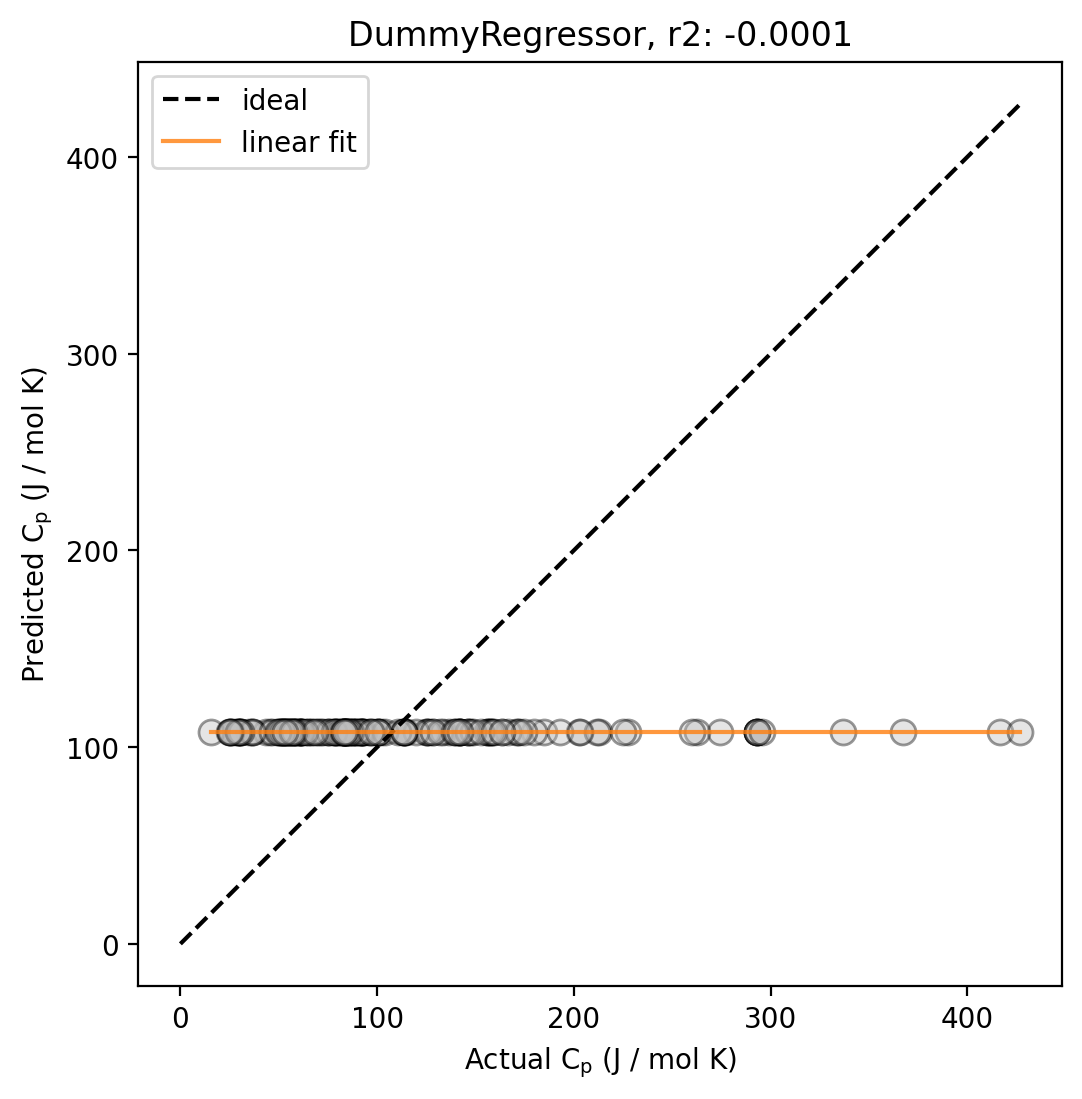

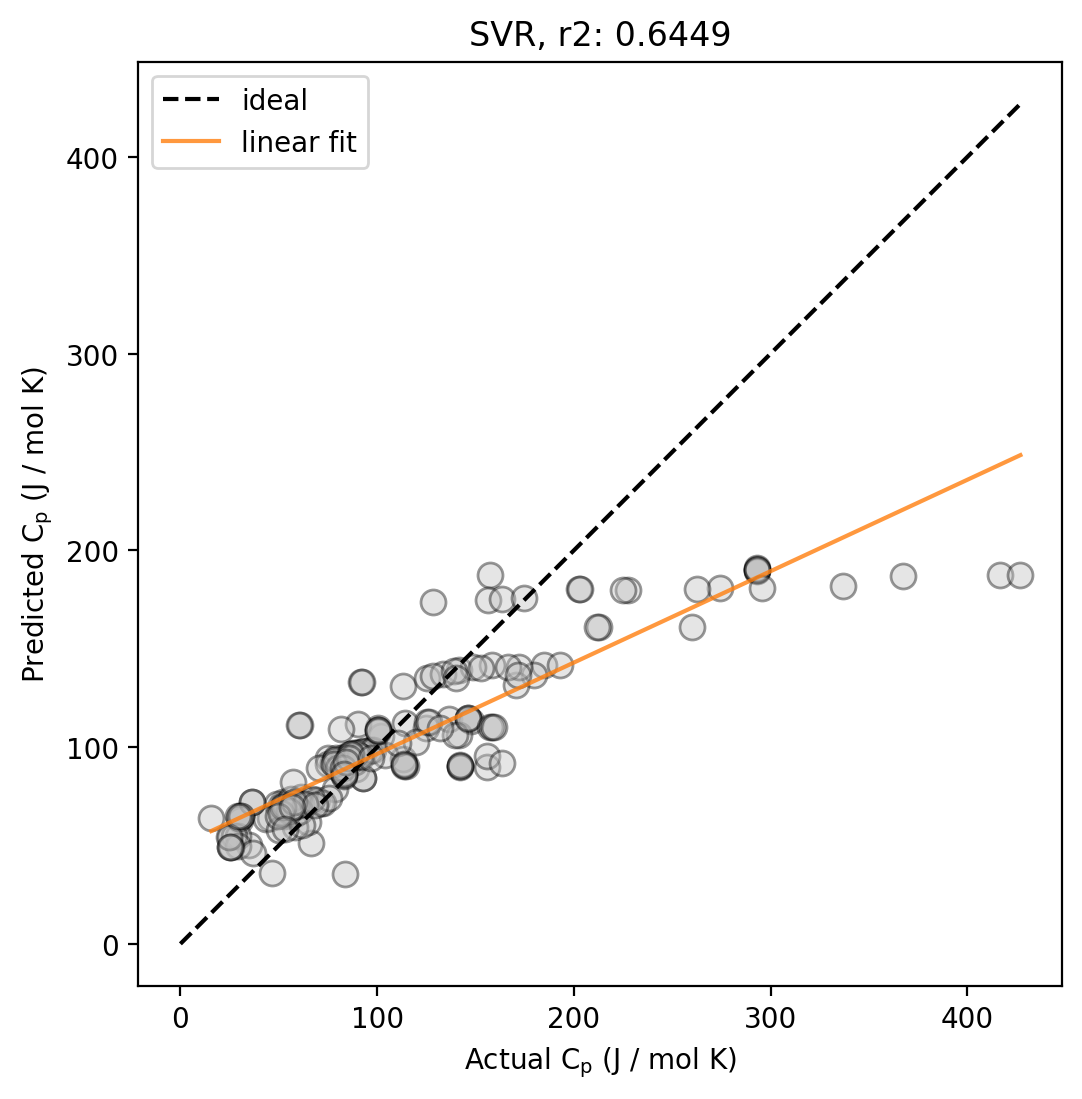

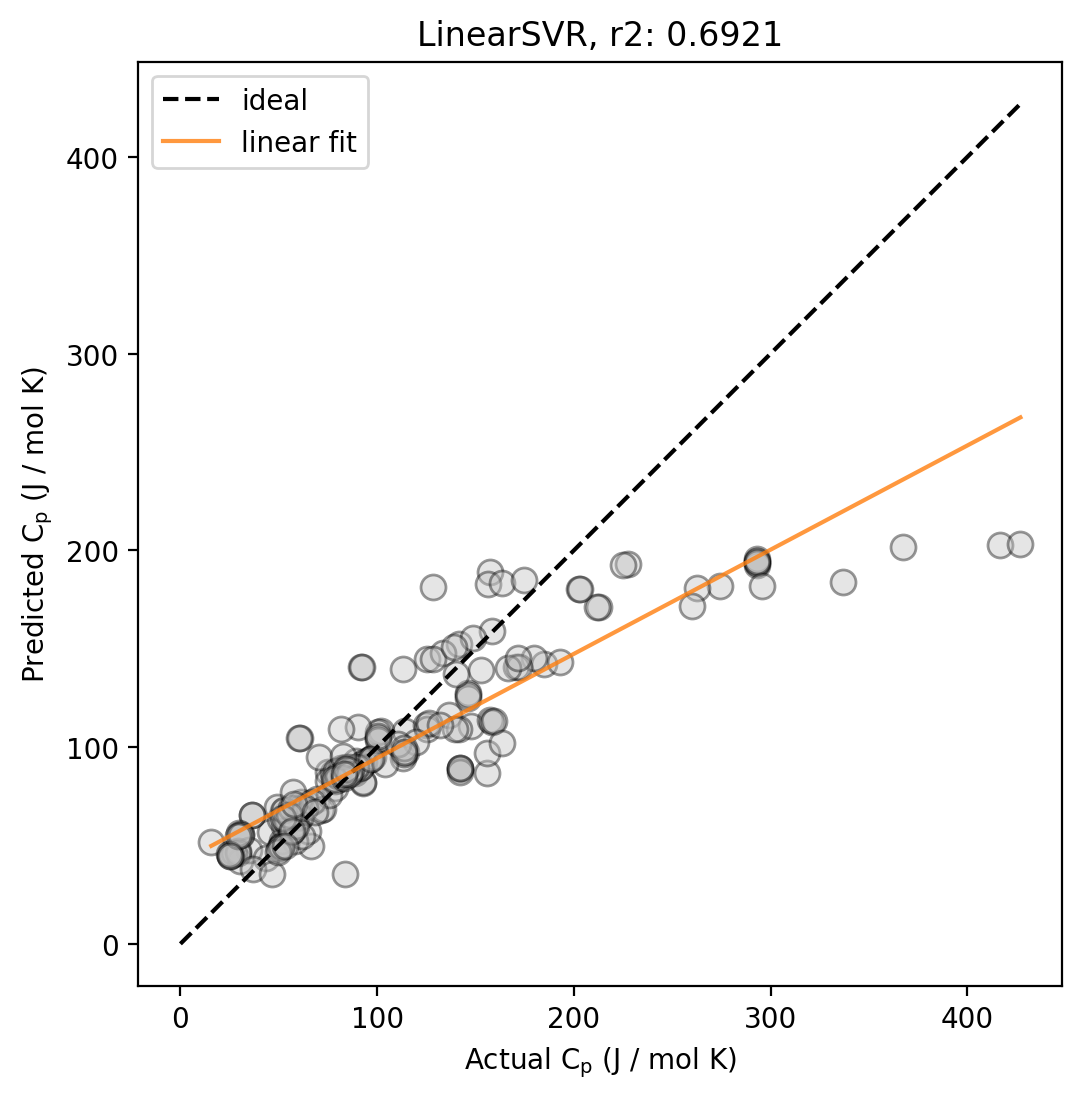

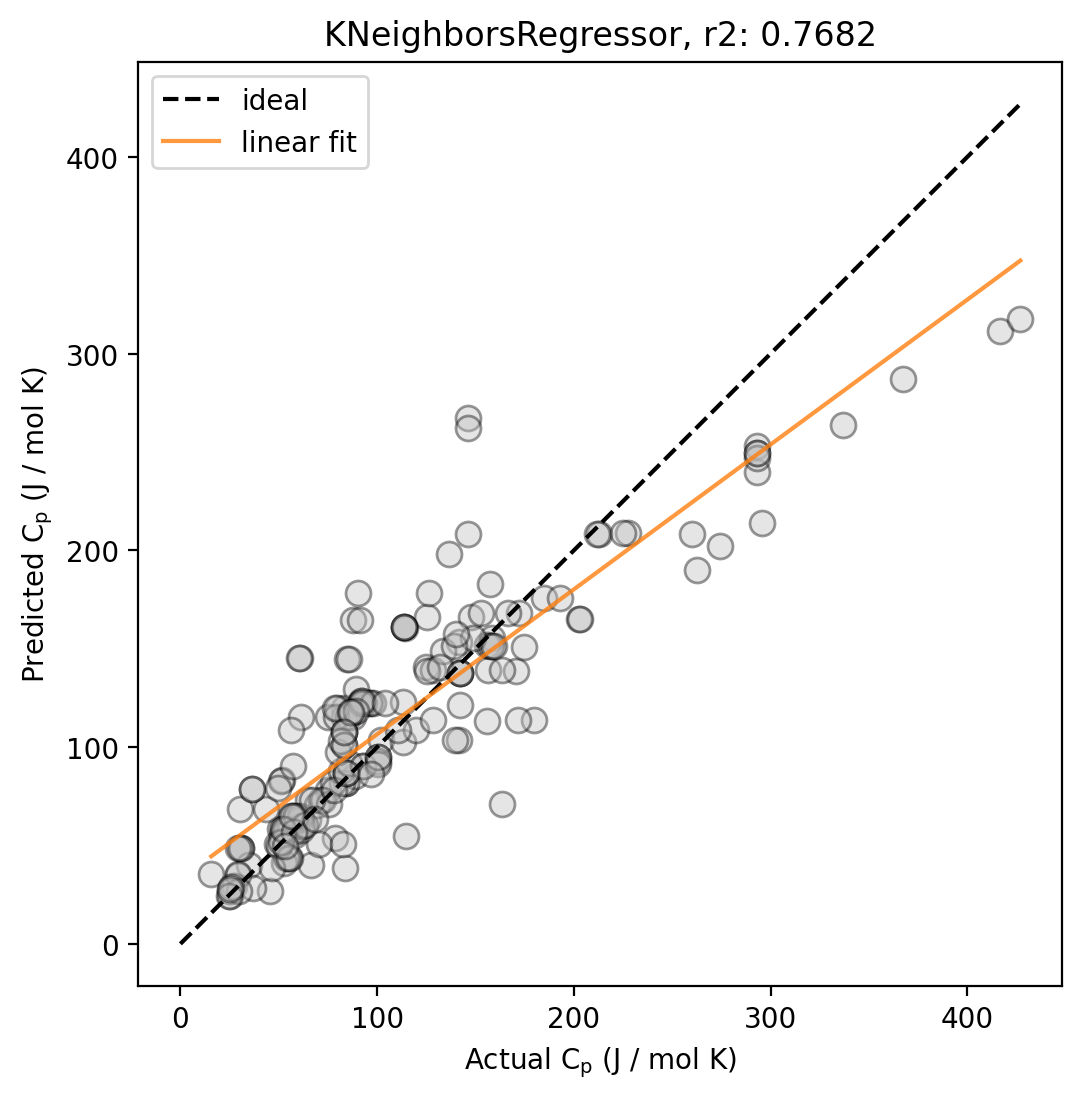

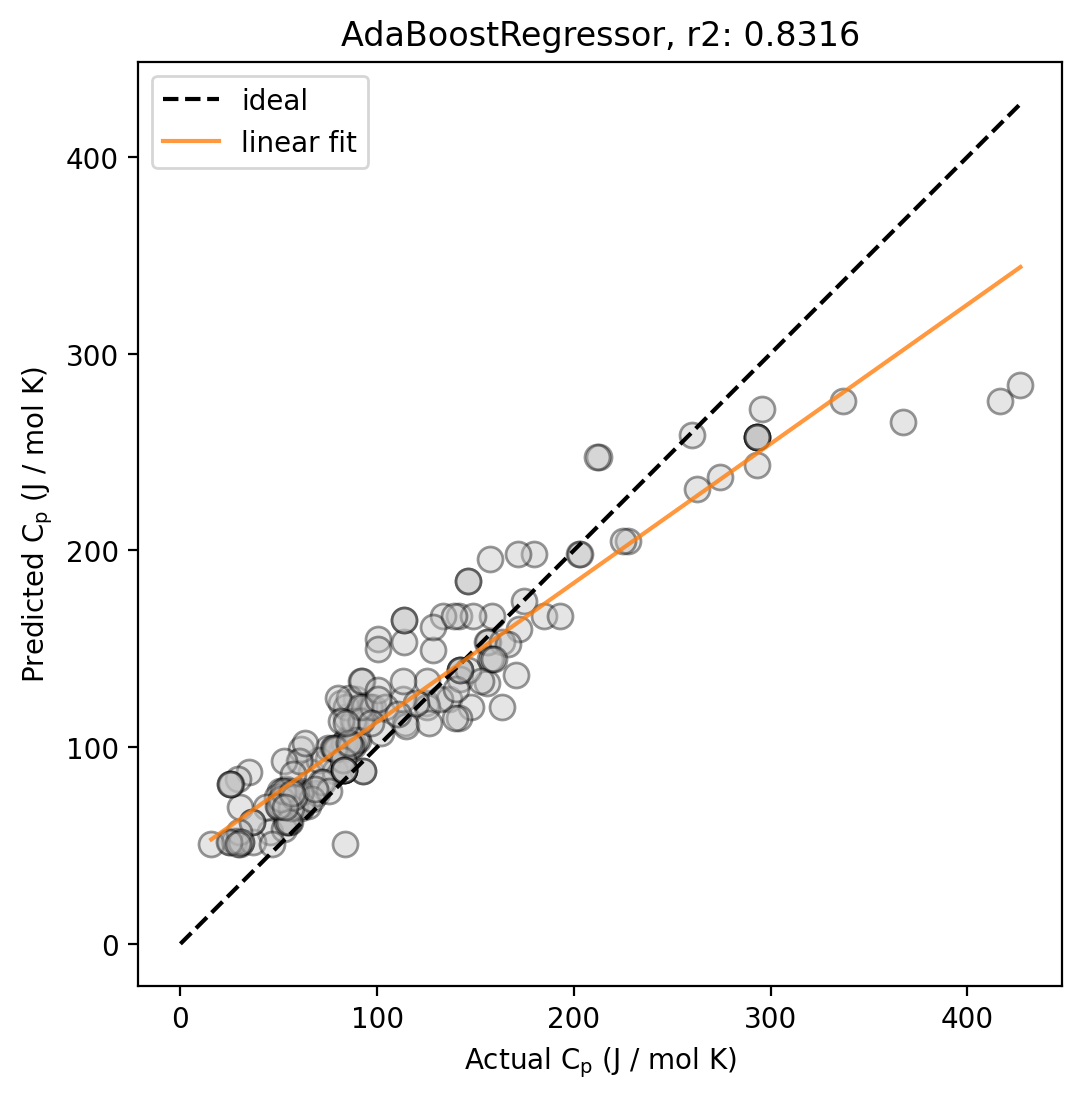

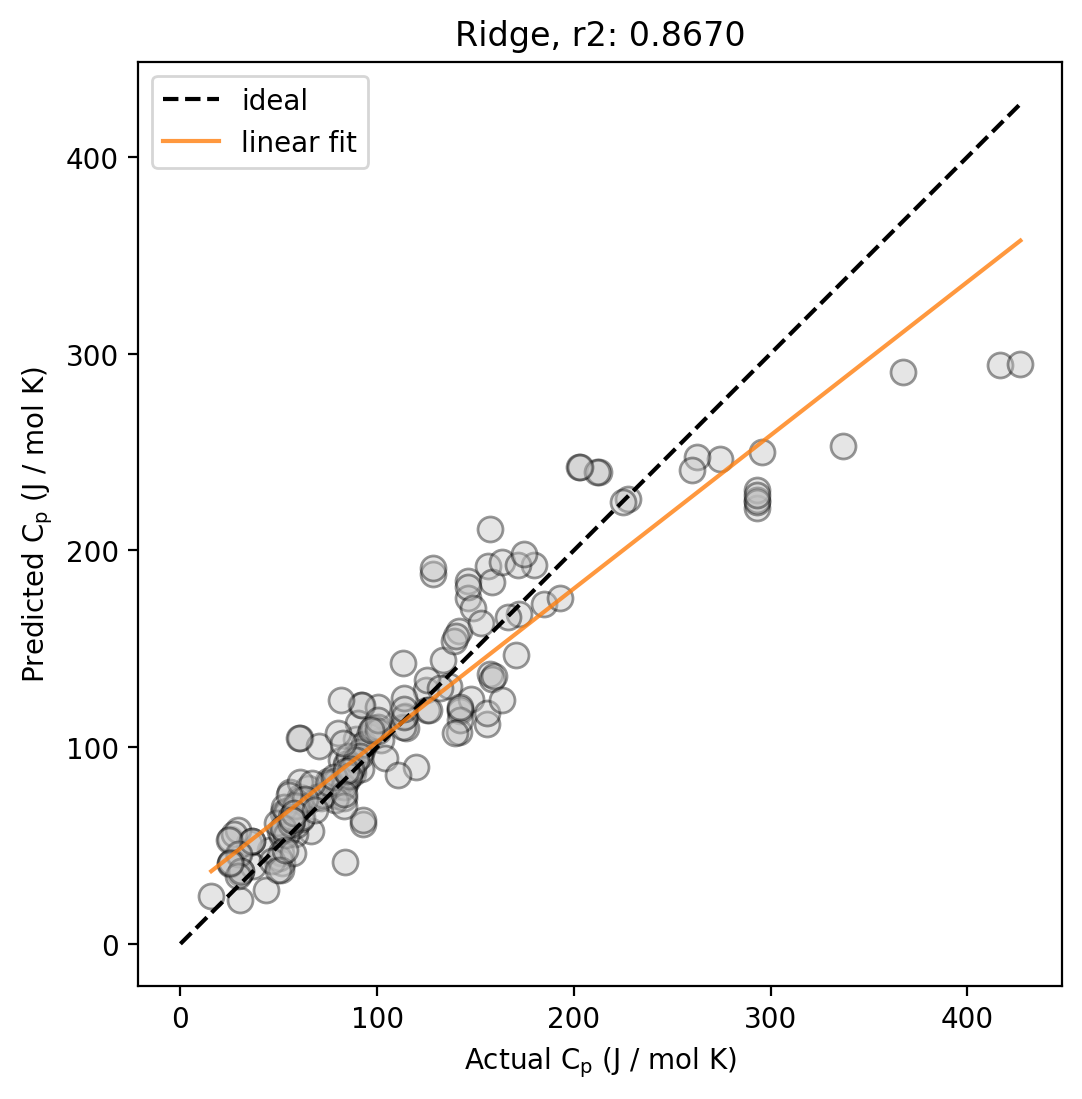

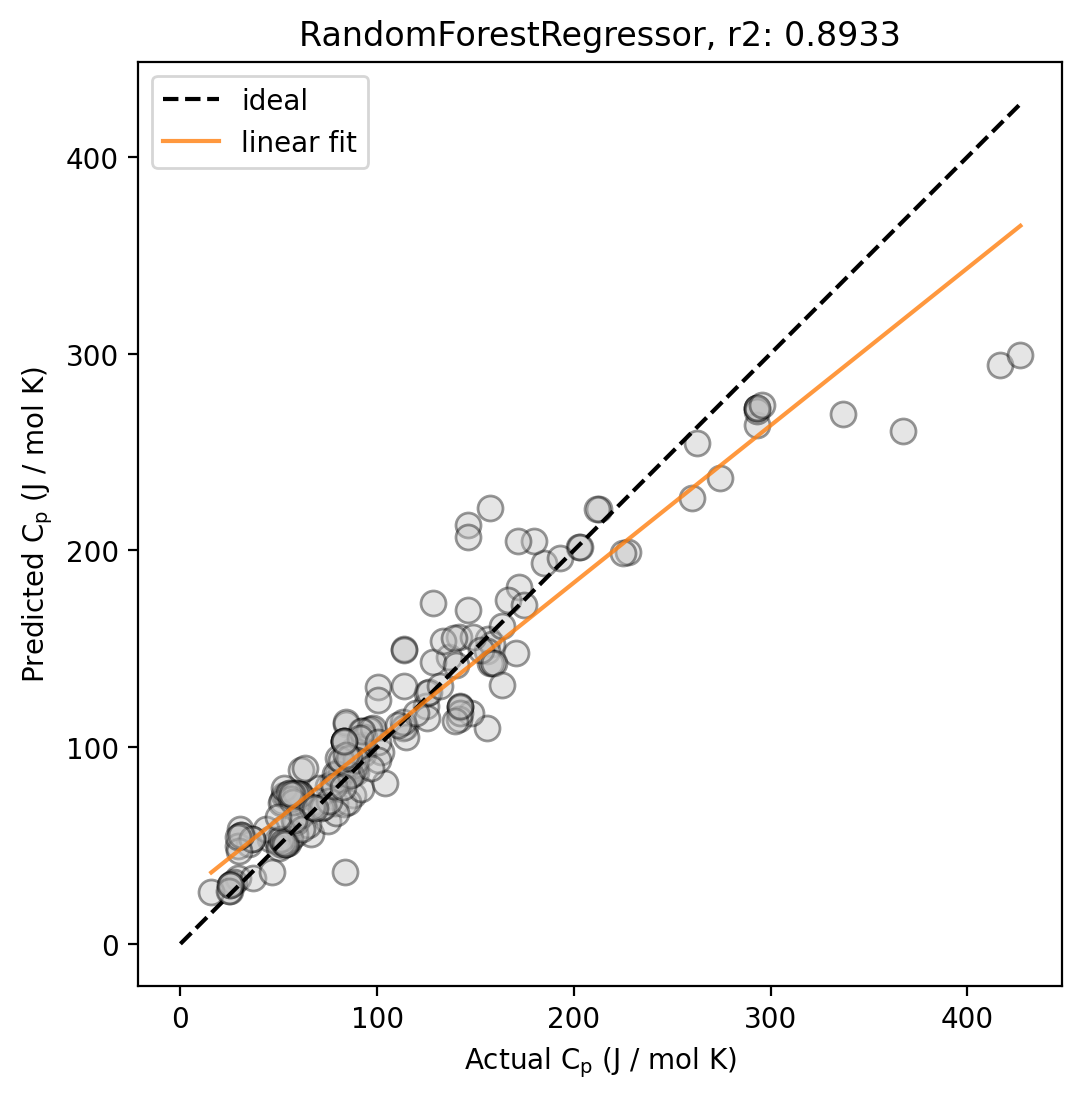

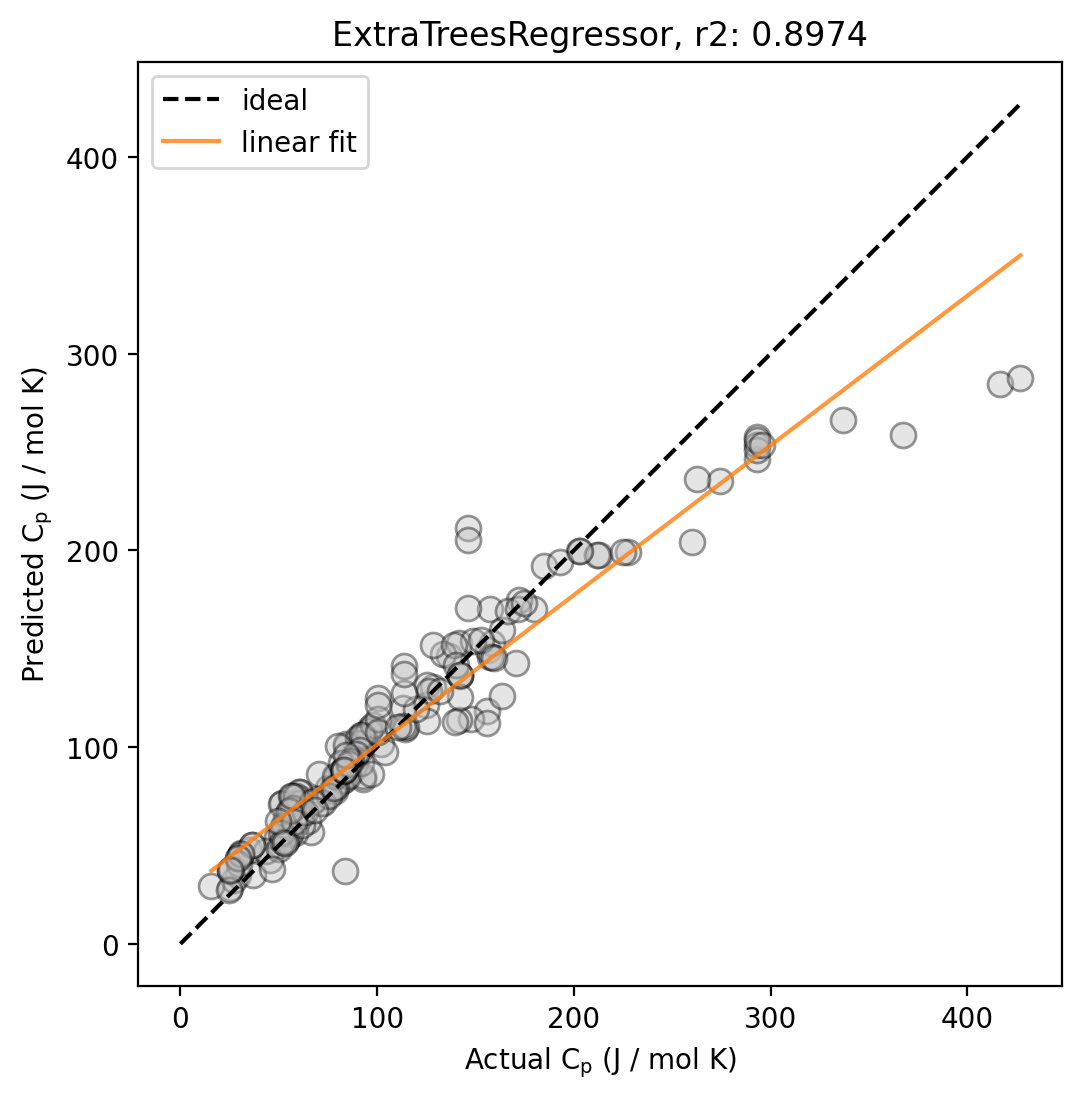

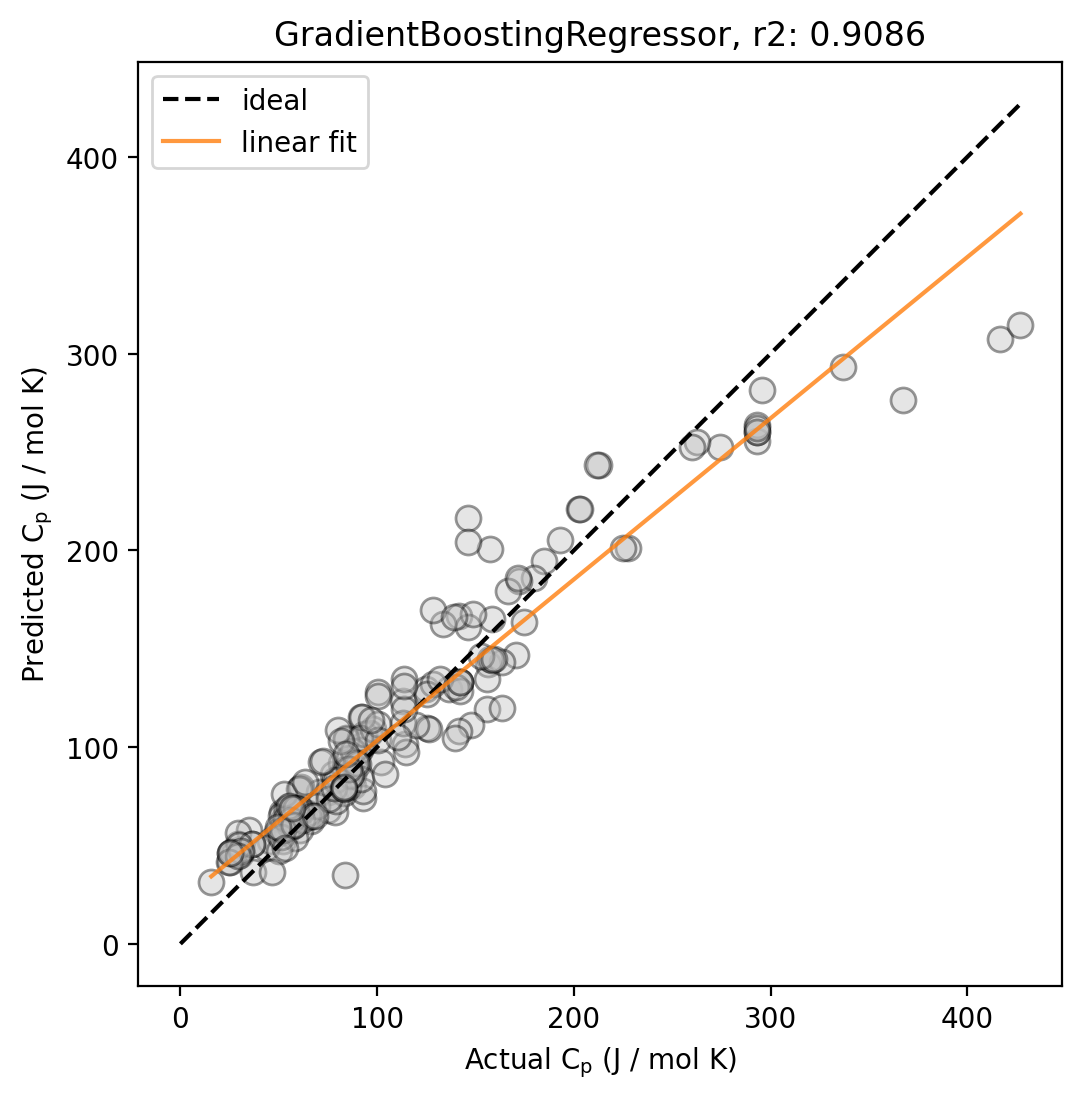

In [109]:
for row in range(df_classics.shape[0]):
    model_name = df_classics.iloc[row]['model_name']

    model = classic_models[model_name]
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

## Re-training the best-performing model on combined train + validation dataset

After you have finalized your model, you can re-train your model (using the same hyperparameters) again on the combined train + validation datasets, and finally, evaluate your model on the held-out test dataset.

By training on the combined train + validation dataset after you have finished tuning your model, you give it more training data, which should lead to an increase in the model performance.

In [110]:
# Find the best-performing model that we have tested
best_row = df_classics.iloc[-1, :].copy()

# Get the model type and model parameters
model_name = best_row['model_name']
model_params = best_row['model_params']

# Instantiate the model again using the parameters
model = classic_model_names[model_name](**model_params)
print(model)

GradientBoostingRegressor()


In [111]:
# Concatenate the train and validation datasets together
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(2200, 309)


Finally, we can fit the model on the combined train + validation dataset.

In [112]:
ti = time()

model.fit(X_train_new, y_train_new)

dt = time() - ti
print(f'Finished fitting best model, total time: {dt:0.2f} s')

Finished fitting best model, total time: 31.77 s


## Testing the re-trained model on the test dataset

After re-fitting the best model on the train+validation dataset, you can finally test it on the test dataset.
**Remember:** you should only do this *once!*

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


r2: 0.8024
mae: 19.1407
rmse: 34.9434


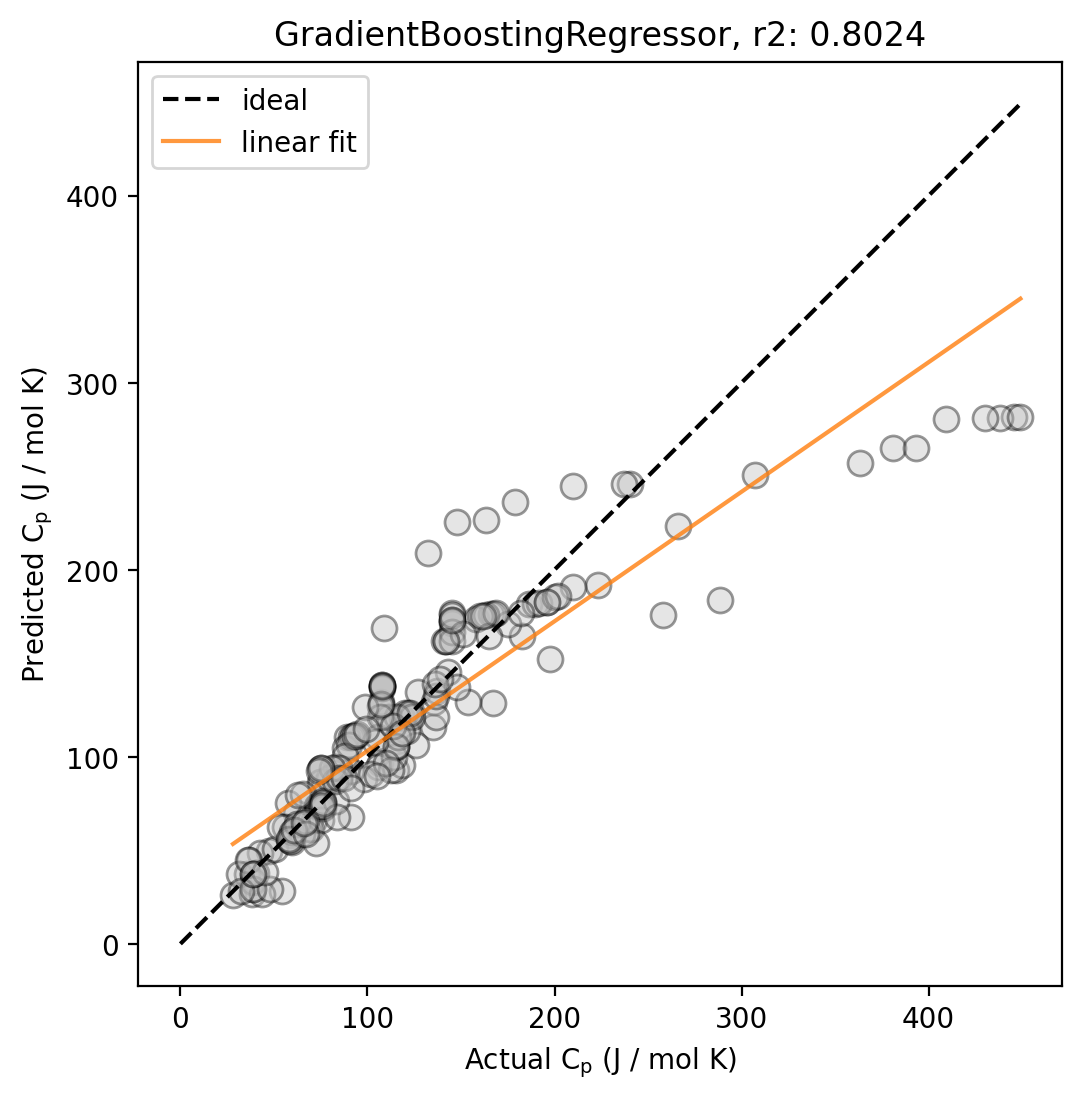

In [113]:
y_act_test = y_test
y_pred_test = model.predict(X_test)

r2, mae, rmse = evaluate_model(model, X_test, y_test)
print(f'r2: {r2:0.4f}')
print(f'mae: {mae:0.4f}')
print(f'rmse: {rmse:0.4f}')

plot = plot_pred_act(y_act_test, y_pred_test, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

We see that our model achieves decent performance on the held-out test dataset.

# Effect of train/validation/test dataset split

Using different train/validation/test splits can dramatically affect your model performance, even for classical ML models.

Here, we provide a little demonstration.

In [114]:
X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 3214/3214 [00:00<00:00, 21160.84it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 3214/3214 [00:00<00:00, 7490.28it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 980/980 [00:00<00:00, 17930.47it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 980/980 [00:00<00:00, 8672.08it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 370/370 [00:00<00:00, 18076.58it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 370/370 [00:00<00:00, 6622.93it/s]


	Creating Pandas Objects...


In [115]:
X_train_original = X_train_unscaled.copy()
X_val = X_val_unscaled.copy()
X_test = X_test_unscaled.copy()

y_train_original = y_train.copy()

We sample the training data using 10 random seeds, by using the `DataFrame.sample()` method with seeds ranging from 0 to 9.
We then fit 10 models, each on one of the random splits, and evaluate their performance on the same validation dataset.

In [124]:
result_dict

{'split': 0,
 'r2_train': 0.92324821137345,
 'mae_train': 14.14879778692623,
 'rmse_train': 16.804990428189818,
 'r2_val': 0.8183114715496764,
 'mae_val': 24.481152206389826,
 'rmse_val': 34.231262113351754}

In [126]:
splits = range(10)
df_splits = pd.DataFrame(columns=['split',
                                  'r2_train',
                                  'mae_train',
                                  'rmse_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])

for split in splits:
    print(f'Fitting and evaluating random split {split}')
    X_train = X_train_original.sample(frac=0.7, random_state=split)
    y_train = y_train_original[X_train.index]

    scaler = StandardScaler()
    X_train = normalize(scaler.fit_transform(X_train))
    X_val = normalize(scaler.transform(X_val_unscaled))
    X_test = normalize(scaler.transform(X_test_unscaled))

    model = AdaBoostRegressor()
    model.fit(X_train, y_train)
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_val)
    result_dict = {
        'split': split,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    rr = pd.DataFrame({'split':[result_dict['split']], 'r2_train':[result_dict['r2_train']], 'mae_train':[result_dict['mae_train']], 'rmse_train':[result_dict['rmse_train']], 'r2_val':[result_dict['r2_val']], 'mae_val':[result_dict['mae_val']],	'rmse_val':[result_dict['rmse_val']]})
    df_splits = pd.concat([df_splits, rr])

Fitting and evaluating random split 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-126-ba93852bcfc6>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_splits = pd.concat([df_splits, rr])


Fitting and evaluating random split 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting and evaluating random split 9


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [127]:
df_splits['split'] = df_splits['split'].astype(int)
df_splits

split  r2_train  mae_train  rmse_train    r2_val    mae_val   rmse_val
0      0  0.924166  14.195391   16.704235  0.806044  24.879373  35.367996
0      1  0.926058  13.647755   16.443971  0.811053  24.219006  34.908349
0      2  0.924971  13.978077   16.806212  0.814380  23.742425  34.599614
0      3  0.928215  13.378901   16.344662  0.816723  22.662894  34.380533
0      4  0.924907  13.929298   16.640296  0.811555  24.818586  34.861941
0      5  0.928458  13.764893   16.281973  0.831586  22.755490  32.957032
0      6  0.926076  13.937148   16.681142  0.811067  24.596327  34.907029
0      7  0.922977  14.115947   16.718927  0.833331  23.822365  32.785900
0      8  0.918994  14.443308   17.183363  0.826618  23.970556  33.439632
0      9  0.925816  13.698999   16.279951  0.823917  23.637712  33.699030

We then plot the train and validation $r^2$ scores for each of the 10 models.

Note the high variability in the r2_val score. In contrast, the variability in the r2_train score is comparatively lower.

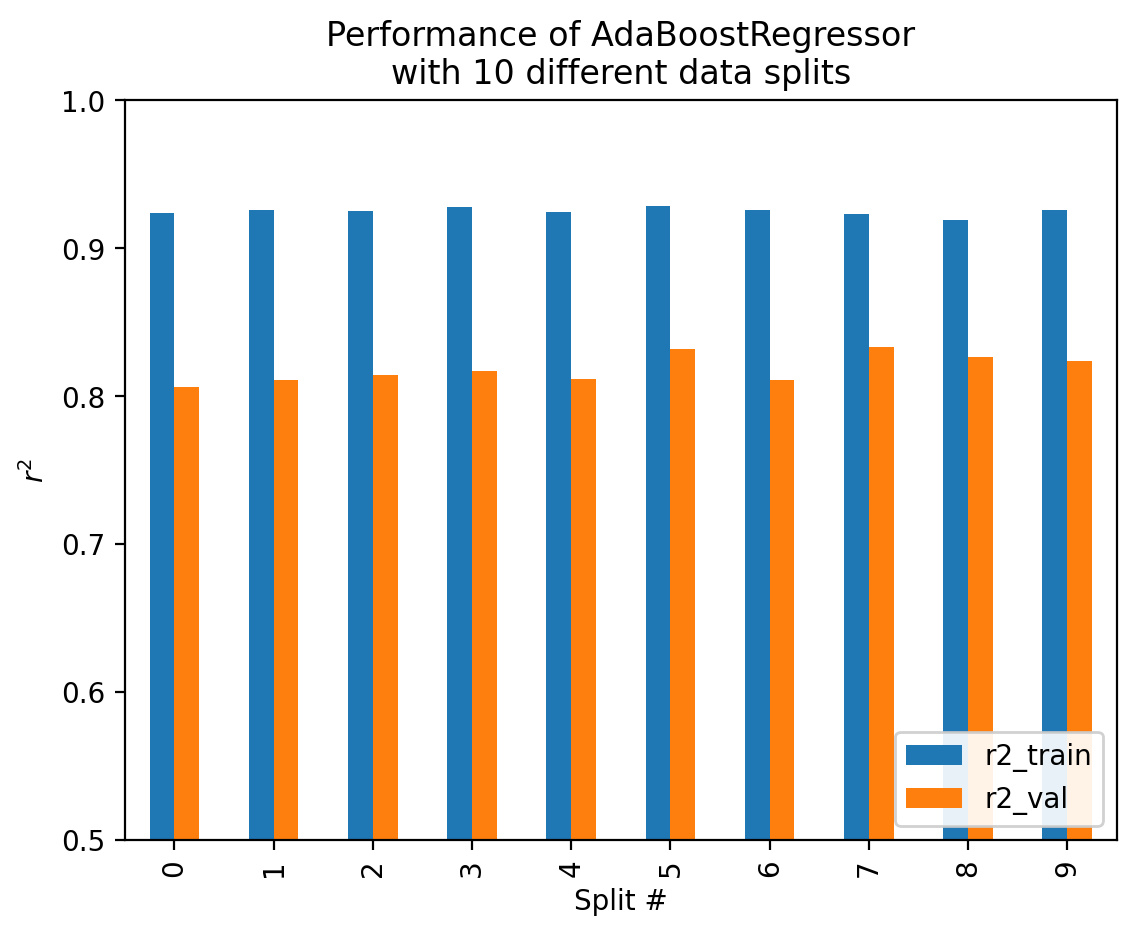

In [128]:
df_splits.plot('split', ['r2_train', 'r2_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylim((0.5, 1.0))
plt.ylabel('$r^2$')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()

This effect is even more pronounced when we plot the mean abolute error (MAE).

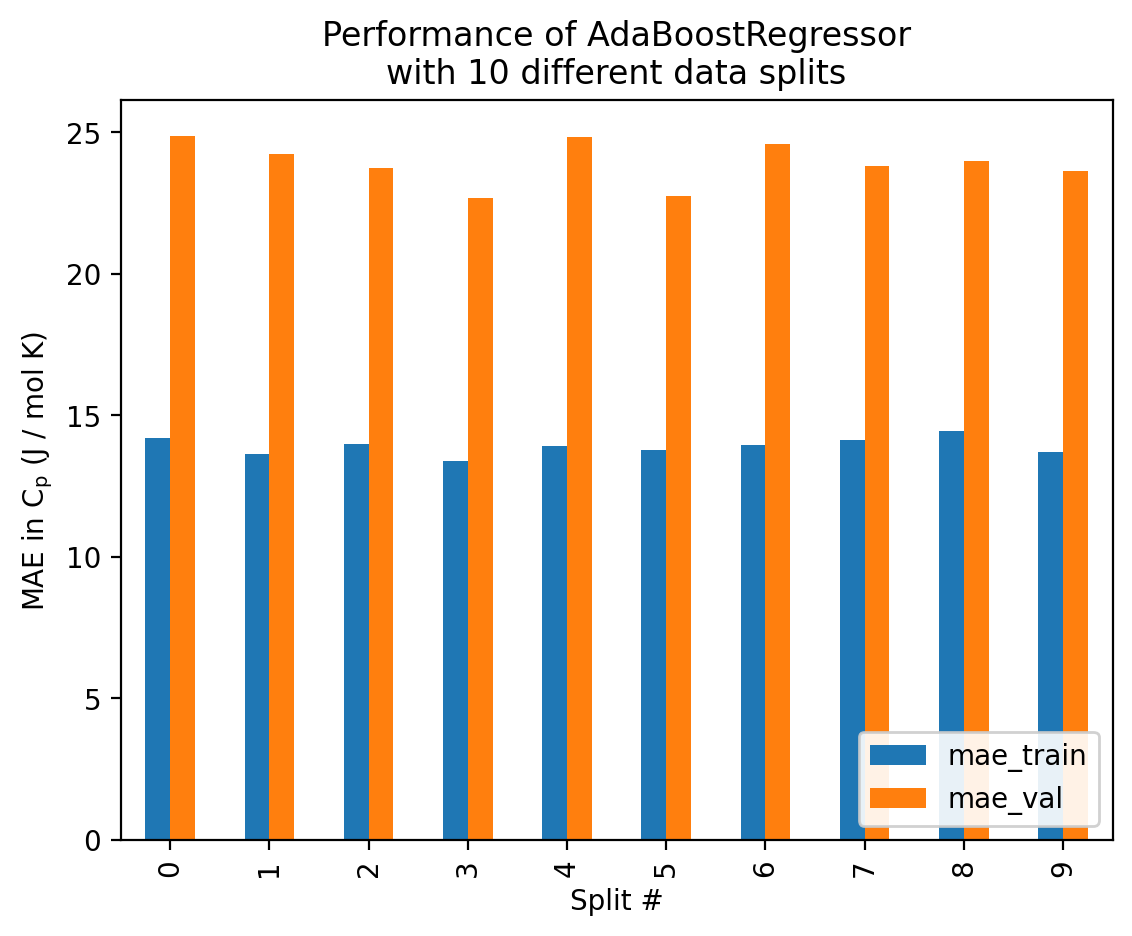

In [129]:
df_splits.plot('split', ['mae_train', 'mae_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylabel('MAE in $\mathrm{C}_\mathrm{p}$ (J / mol K)')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()

Therefore, typically the average value of all the scores are reported, as this gives a much more accurate estimate of how well the model actually performs.

In [130]:
avg_r2_val = df_splits['r2_val'].mean()
avg_mae_val = df_splits['mae_val'].mean()

print(f'Average validation r2: {avg_r2_val:0.4f}')
print(f'Average validation MAE: {avg_mae_val:0.4f}')

Average validation r2: 0.8186
Average validation MAE: 23.9105


# Modeling using neural network / deep learning-based models

In this notebook, we will cover how to implement a simple neural network for the modeling of heat capacity.

We will load, prepare featurize, and scale/normalize the input datasets the same way as we did in the pervious notebook. For more information about the individual steps, you can consult that notebook.

In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

from CBFV import composition

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim


# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

## Featurizing and scaling data

Nothing new here---same steps as we've done in the previous notebook.

In [132]:
PATH = os.getcwd()
train_path = os.path.join(PATH, 'cp_train.csv')
val_path = os.path.join(PATH, 'cp_val.csv')
test_path = os.path.join(PATH, 'cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (3214, 3)
df_val DataFrame shape: (980, 3)
df_test DataFrame shape: (370, 3)


Here we do not sub-sample the datasets into smaller datasets like we did in the previous notebook.
Typically, the more data you have for neural networks, the better the networks will be able to train, and the better they will perform (as long as they are well-conditioned).

Additionally, the performance of `PyTorch` is very good for modern computers, especially if you have a modern CUDA-capable graphics processing unit (GPU) such as an Nvidia GPU to accelerate the computations.
Our dataset is small enough to fit into almost all modern computers or CUDA-capable GPUs.

In [133]:
rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 3214/3214 [00:00<00:00, 11772.65it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 3214/3214 [00:00<00:00, 3863.83it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 980/980 [00:00<00:00, 6375.39it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 980/980 [00:00<00:00, 3233.24it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 370/370 [00:00<00:00, 9914.41it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 370/370 [00:00<00:00, 3341.33it/s]


	Creating Pandas Objects...


In [134]:
X_train_unscaled.head()

sum_Atomic_Number  sum_Atomic_Weight  sum_Period  sum_group  sum_families  \
0               34.0            69.6202        10.0       74.0          33.0   
1               34.0            69.6202        10.0       74.0          33.0   
2               34.0            69.6202        10.0       74.0          33.0   
3               34.0            69.6202        10.0       74.0          33.0   
4               34.0            69.6202        10.0       74.0          33.0   

   sum_Metal  sum_Nonmetal  sum_Metalliod  sum_Mendeleev_Number  \
0        0.0           3.0            2.0                 405.0   
1        0.0           3.0            2.0                 405.0   
2        0.0           3.0            2.0                 405.0   
3        0.0           3.0            2.0                 405.0   
4        0.0           3.0            2.0                 405.0   

   sum_l_quantum_number  ...  mode_Melting_point_(K)  mode_Boiling_Point_(K)  \
0                   5.0  ...                   54.75                   90.15   
1                   5.0  ...                   54.75                   90.15   
2                   5.0  ...                   54.75                   90.15   
3                   5.0  ...                   54.75                   90.15   
4                   5.0  ...                   54.75                   90.15   

   mode_Density_(g/mL)  mode_specific_heat_(J/g_K)_  \
0              0.00143                         0.92   
1              0.00143                         0.92   
2              0.00143                         0.92   
3              0.00143                         0.92   
4              0.00143                         0.92   

   mode_heat_of_fusion_(kJ/mol)_  mode_heat_of_vaporization_(kJ/mol)_  \
0                        0.22259                               3.4099   
1                        0.22259                               3.4099   
2                        0.22259                               3.4099   
3                        0.22259                               3.4099   
4                        0.22259                               3.4099   

   mode_thermal_conductivity_(W/(m_K))_  mode_heat_atomization(kJ/mol)  \
0                               0.02674                          249.0   
1                               0.02674                          249.0   
2                               0.02674                          249.0   
3                               0.02674                          249.0   
4                               0.02674                          249.0   

   mode_Cohesive_energy       T  
0                  2.62  1400.0  
1                  2.62  1300.0  
2                  2.62  1200.0  
3                  2.62  1100.0  
4                  2.62  1000.0  

[5 rows x 309 columns]

In [135]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

## Building a neural network

This is where you get to be the architect, and design your own neural network!

For sake of clarity (and to ensure that this tutorial runs on all the potatoes of this world), we will define a simple dense fully-connected neural network (which we will call `DenseNet`) as an example.

The input layer of `DenseNet` accepts input data in the dimension of each row of the input data, which is equal to the number of features in our CBFV featurization scheme.
In our particular example, when featurized using the `oliynyk` featurizer, the input dimension is 177 (it is the second dimension when you view `X_train.shape`).

The output layer dimension of `DenseNet` is 1, because we want to predict one value (heat capacity).

In addition, `DenseNet` can have one or more "hidden layers" that are attached between the input and output layers. These can be any arbitrary dimensions $>1$ you want to choose.

### Defining the network in PyTorch

In [136]:
import torch.nn as nn
import torch
class DenseNet(nn.Module):
    """
    This implements a dynamically-built dense fully-connected neural network
    with leaky ReLU activation and optional dropout.

    Parameters
    ----------
    input_dims: int
        Number of input features (required).
    hidden_dims: list of ints
        Number of hidden features, where each integer represents the number of
        hidden features in each subsequent hidden linear layer (optional,
        default=[64, 32]).
    output_dims: int
        Number of output features (optional, default=1).
    dropout: float
        the dropout value (optional, default=0.0).
    """
    def __init__(self,
                 input_dims,
                 hidden_dims=[64, 32],
                 output_dims=1,
                 dropout=0.0):
        super().__init__()

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        self.dropout = dropout

        # Build a sub-block of linear networks
        def fc_block(in_dim, out_dim, *args, **kwargs):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim, *args, **kwargs),
                nn.Dropout(p=self.dropout),
                nn.LeakyReLU()
                )

        # Build overall network architecture
        self.network = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(input_dims, self.hidden_dims[0]),
                    nn.Dropout(p=self.dropout),
                    nn.LeakyReLU())
                ]
            )

        hidden_layer_sizes = zip(self.hidden_dims[:-1], self.hidden_dims[1:])
        self.network.extend([
            fc_block(in_dim, out_dim) for in_dim, out_dim
            in hidden_layer_sizes]
            )

        self.network.extend([
            nn.Linear(hidden_dims[-1], output_dims)]
            )


    def forward(self, x):
        """
        Forward pass of the DenseNet model.

        Parameters
        ----------
        x: torch.Tensor
            A representation of the chemical compounds in the shape
            (n_compounds, n_feats).

        Returns
        -------
        y: torch.Tensor
            The element property prediction with the shape 1.
        """
        for i, subnet in enumerate(self.network):
            x = subnet(x)

        y = x

        return y

### Specifying the compute device for calculations

Before we run the neural network, we can first check if your machine has a CUDA-capable device.
CUDA is a specific set of application instructions (application programming interfaces, APIs) that PyTorch can use to accelerate some of the calculations performed in neural networks.

Generally, a relatively recent GPU from Nvidia will support CUDA capabilities, and can be used to accelerate neural network computations in PyTorch.

In case you do not have a CUDA-capable device, PyTorch will fall back to using the CPU. Depending on the complexity of your model, training and predicting using a CPU can take significantly longer than using a CUDA-capable GPU.

Consult the [PyTorch](https://pytorch.org/docs/stable/torch.html) and [CUDA](https://docs.nvidia.com/cuda/) documentation for more information.

In [137]:
CUDA_available = torch.cuda.is_available()
print(f'CUDA is available: {CUDA_available}')

if CUDA_available:
    compute_device = torch.device('cuda')
else:
    compute_device = torch.device('cpu')

print(f'Compute device for PyTorch: {compute_device}')

CUDA is available: False
Compute device for PyTorch: cpu


### Defining the data loader and dataset structure

Here we define a dataloader class specific for loading CBFV-type datasets.

We also define the CBFV dataset class that tells PyTorch how our dataset is structured, and how to grab individual data samples from our dataset.

In [138]:
class CBFVDataLoader():
    """
    Parameters
    ----------
    train_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    val_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    test_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    batch_size: float, optional (default=64)
        Step size for the Gaussian filter
    random_state: int, optional (default=42)
        Random seed for sampling the dataset. Only used if validation data is
        not given.
    shuffle: bool, optional (default=True)
        Whether to shuffle the datasets or not
    """
    def __init__(self, train_data, val_data, test_data,
                 batch_size=64, num_workers=1, random_state=42,
                 shuffle=True, pin_memory=True):

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        self.shuffle = shuffle
        self.random_state = random_state


    def get_data_loaders(self, batch_size=1):
        '''
        Input the dataset, get train test split
        '''
        train_dataset = CBFVDataset(self.train_data)
        val_dataset = CBFVDataset(self.val_data)
        test_dataset = CBFVDataset(self.test_data)

        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  pin_memory=self.pin_memory,
                                  shuffle=self.shuffle)

        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                pin_memory=self.pin_memory,
                                shuffle=self.shuffle)

        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        return train_loader, val_loader, test_loader


class CBFVDataset(Dataset):
    """
    Get X and y from CBFV-based dataset.
    """
    def __init__(self, dataset):
        self.data = dataset

        self.X = np.array(self.data[0])
        self.y = np.array(self.data[1])
        self.shape = [(self.X.shape), (self.y.shape)]

    def __str__(self):
        string = f'CBFVDataset with X.shape {self.X.shape}'
        return string

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[[idx], :]
        y = self.y[idx]

        X = torch.as_tensor(X)
        y = torch.as_tensor(np.array(y))

        return (X, y)

Here we choose a batch size for loading data, and initialize the DataLoader for loading the featurized input data.

We also get the data loaders corresponding to the train, validation, and test datasets.

In [139]:
train_data = (X_train, y_train)
val_data = (X_val, y_val)
test_data = (X_test, y_test)

# Instantiate the DataLoader
batch_size = 128
data_loaders = CBFVDataLoader(train_data, val_data, test_data, batch_size=batch_size)
train_loader, val_loader, test_loader = data_loaders.get_data_loaders()

### Instantiating a `DenseNet` model

Now, we can instantiate... an instance of the `DenseNet` model.

In [140]:
# Get input dimension size from the dataset
example_data = train_loader.dataset.data[0]
input_dims = example_data.shape[-1]

# Instantiate the model
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
print(model)

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=309, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


### Defining the loss criterion & optimizer

Here, we see the model and its individual layers and components printed nicely.

We then instantiate and initialize the loss criterion and optimizer.

Note, there are many choices of loss criteria and optimizers that are provided by PyTorch, each with their benefits and limitations, and a myriad of parameters.
Consult the PyTorch documentation for further details.

In [141]:
# Initialize the loss criterion
criterion = nn.L1Loss()
print('Loss criterion: ')
print(criterion)

# Initialize the optimzer
optim_lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=optim_lr)
print('\nOptimizer: ')
print(optimizer)

Loss criterion: 
L1Loss()

Optimizer: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


### Moving the model to the compute device

Then, we can move the model and loss criterion computation to the compute device.

If you have a GPU, this will trasnfer and attach the required resources to the GPU. If you have a CPU, then everything will remain on the CPU.

In [142]:
# Move the model and criterion to the compute device
model = model.to(compute_device)
criterion = criterion.to(compute_device)

### Defining some additional helper functions

We define some scaler functions and helper functions to evaluate and visualize model results.

In [143]:
class Scaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (data - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled)
        data = data_scaled * self.std + self.mean
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


class MeanLogNormScaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.logdata = torch.log(self.data)
        self.mean = torch.mean(self.logdata)
        self.std = torch.std(self.logdata)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (torch.log(data) - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled) * self.std + self.mean
        data = torch.exp(data_scaled)
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [144]:
def predict(model, data_loader):
    target_list = []
    pred_list = []

    model.eval()
    with torch.no_grad():
        for i, data_output in enumerate(data_loader):
            X, y_act = data_output
            X = X.to(compute_device,
                     dtype=data_type,
                     non_blocking=True)
            y_act = y_act.cpu().flatten().tolist()
            y_pred = model.forward(X).cpu().flatten().tolist()

            # Unscale target values
            y_pred = target_scaler.unscale(y_pred).tolist()

            targets = y_act
            predictions = y_pred
            target_list.extend(targets)
            pred_list.extend(predictions)
    model.train()

    return target_list, pred_list


def evaluate(target, pred):
    r2 = r2_score(target, pred)
    mae = mean_absolute_error(target, pred)
    rmse = mean_squared_error(target, pred, squared=False)
    output = (r2, mae, rmse)
    return output


def print_scores(scores, label=''):
    r2, mae, rmse = scores
    print(f'{label} r2: {r2:0.4f}')
    print(f'{label} mae: {mae:0.4f}')
    print(f'{label} rmse: {rmse:0.4f}')
    return scores


def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')

    return plot

We scale the target variables.

In [145]:
y_train = [data[1].numpy().tolist() for data in train_loader]
y_train = [item for sublist in y_train for item in sublist]

y_train = train_loader.dataset.y

target_scaler = MeanLogNormScaler(y_train)

### Training the neural network

And finally, we train the neural network.

This is the training procedure for the neural network:
* for each `epoch`:
  * iterate through the train dataset using `train_loader`:
    * scale the target data
    * transfer input (`X`) and target (`y`) data to compute device
    * reset the optimizer's gradient to zero
    * compute the output of the model (forward pass)
    * calculate the loss of the model (between the predicted and true target values)
    * propagate the loss backwards through the model (backpropagation)
    * update the weights throughout the model
  * if `epoch == print_every`:
    * print the current epoch (to keep track of training progress)
  * if `epoch == plot_every`:
    * evaluate the model on the validation dataset using `val_loader`
    * plot predicted vs. actual value plots
    * print the train and val $r^2$, $\textrm{MAE}$ and $\textrm{RMSE}$ scores of the model

Note: training this network may take up to tens of minutes, depending on your hardware configuration and whether or not you have a CUDA-capable device.

epoch: 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: -0.0286
train mae: 46.3813
train rmse: 61.4988
val r2: -0.0148
val mae: 54.8115
val rmse: 80.9016


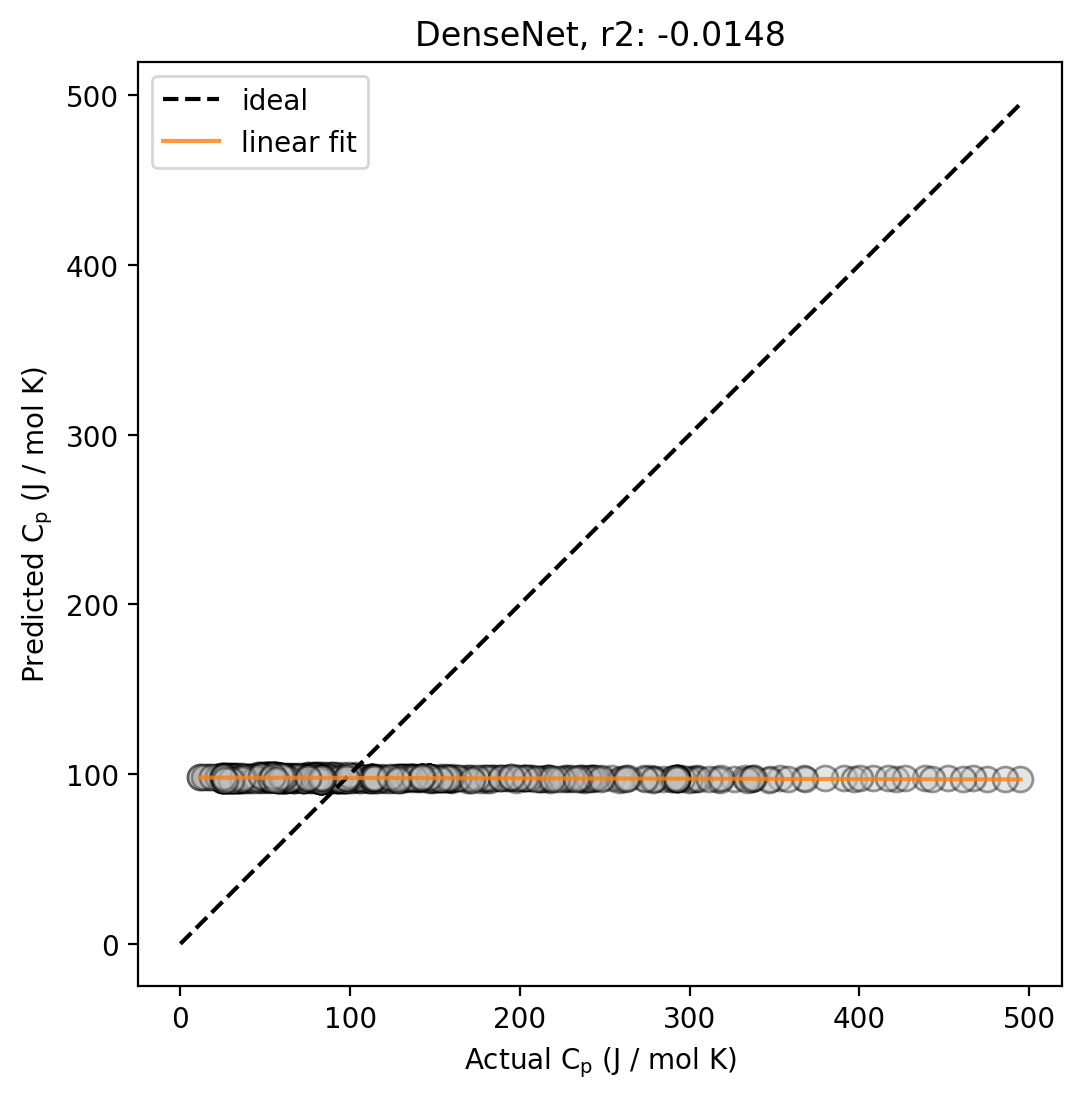

epoch: 20
epoch: 40


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: 0.9798
train mae: 4.3997
train rmse: 8.6231
val r2: 0.8936
val mae: 15.0336
val rmse: 26.1971


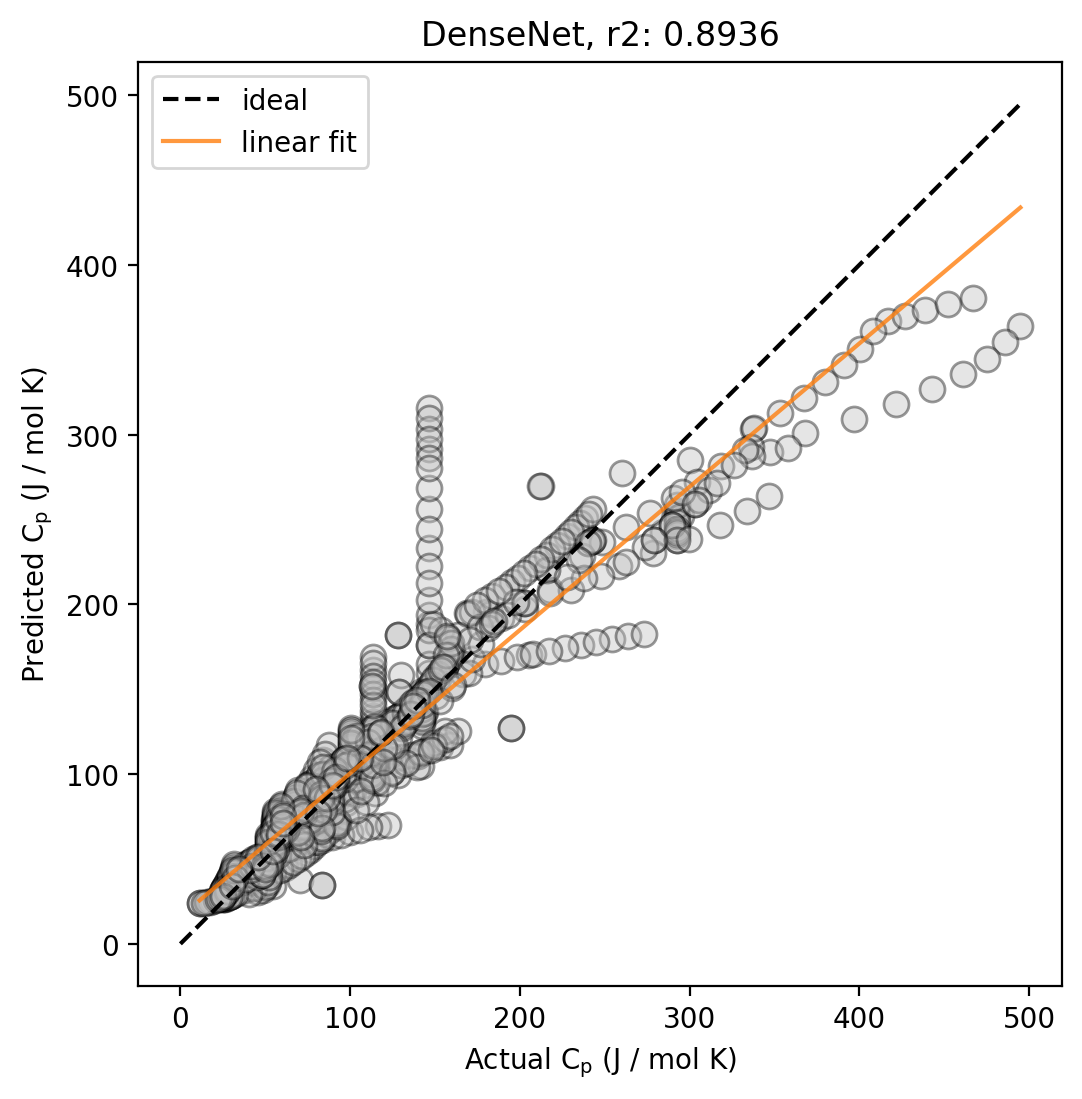

epoch: 60
epoch: 80
epoch: 100
train r2: 0.9830
train mae: 3.9272
train rmse: 7.9159
val r2: 0.8937
val mae: 15.4170
val rmse: 26.1822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


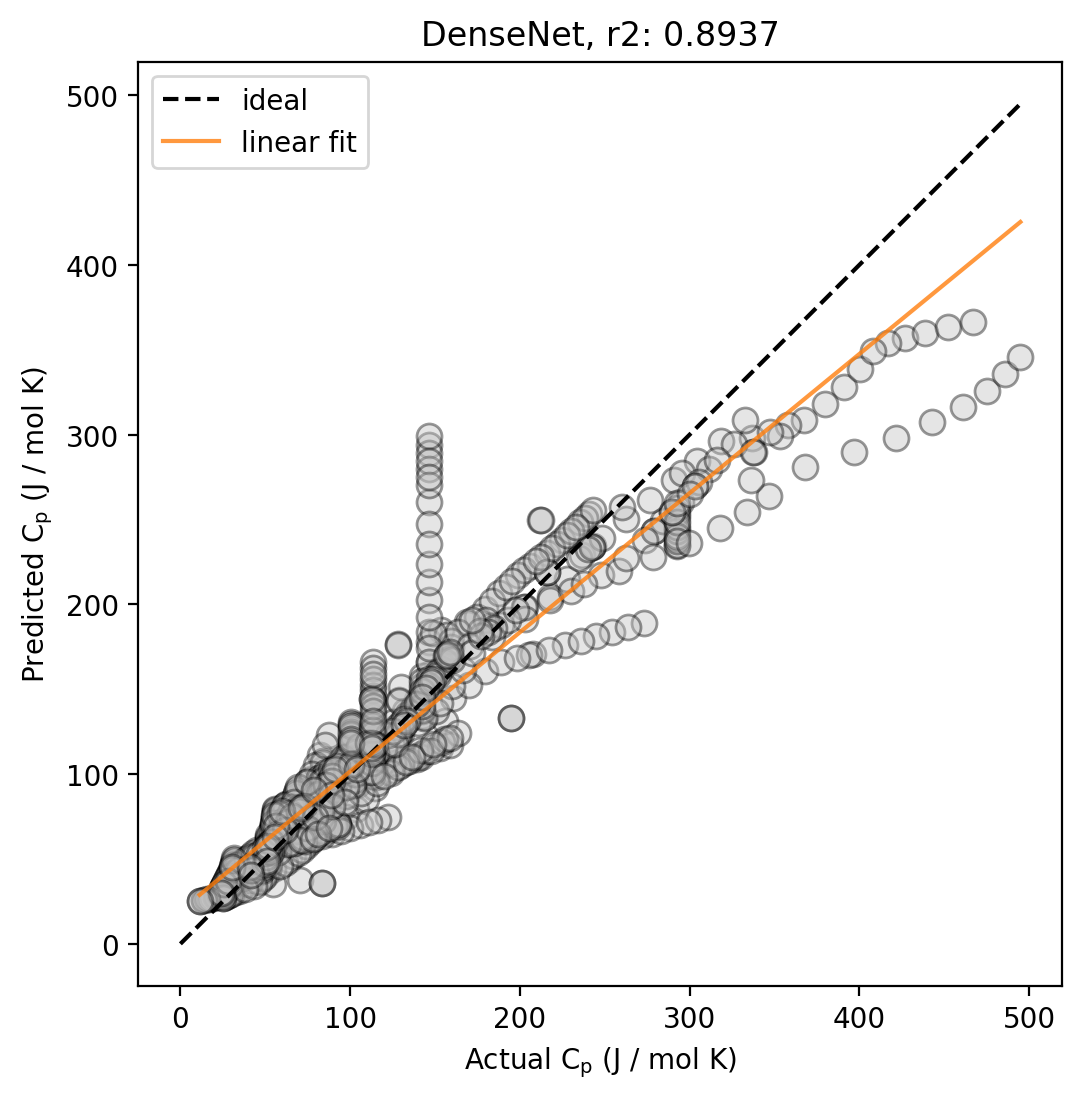

epoch: 120
epoch: 140


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: 0.9840
train mae: 3.7696
train rmse: 7.6722
val r2: 0.9094
val mae: 14.7780
val rmse: 24.1666


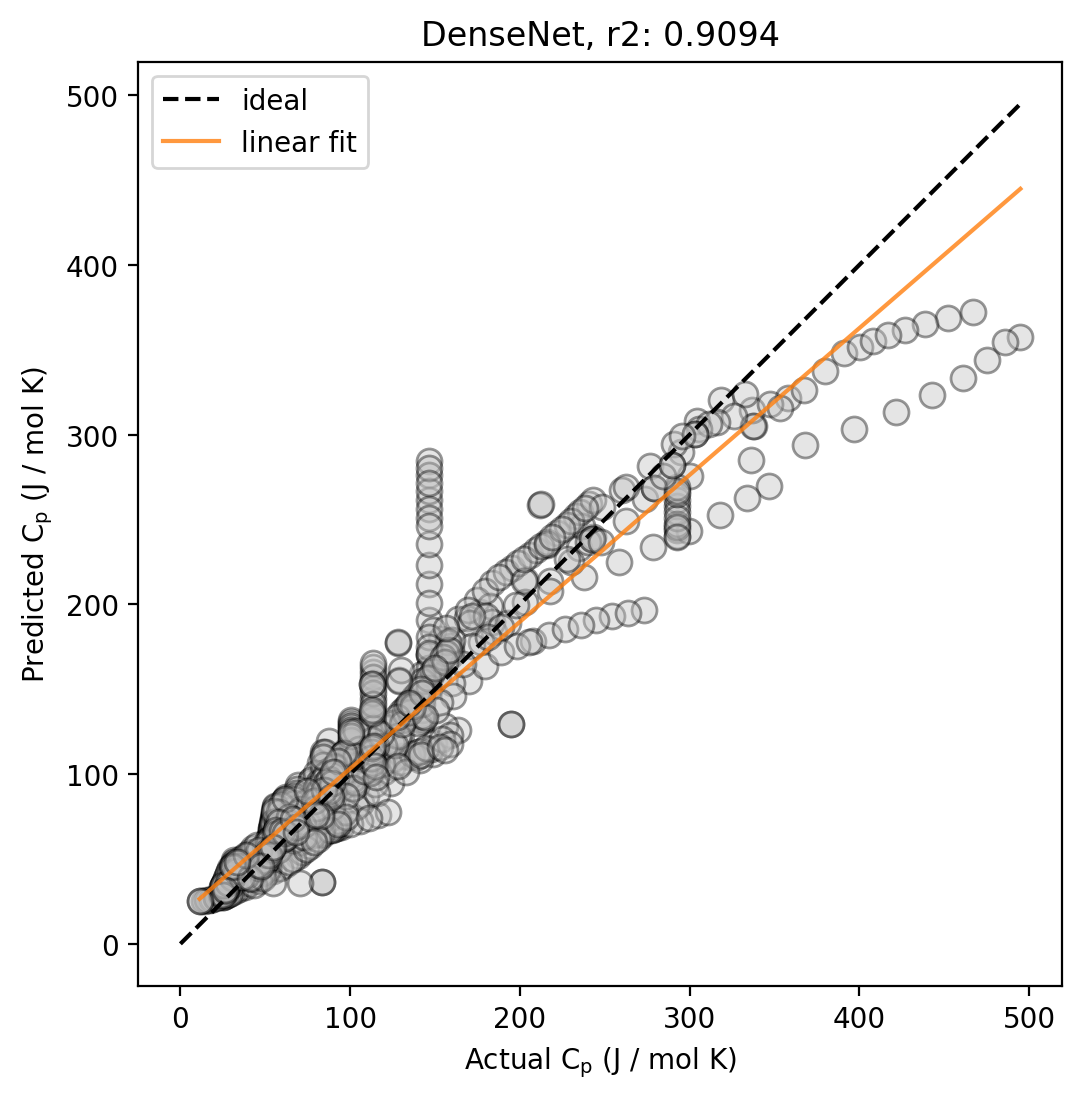

epoch: 160
epoch: 180
epoch: 200
train r2: 0.9853
train mae: 3.7115
train rmse: 7.3447
val r2: 0.9034
val mae: 15.0202
val rmse: 24.9649


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


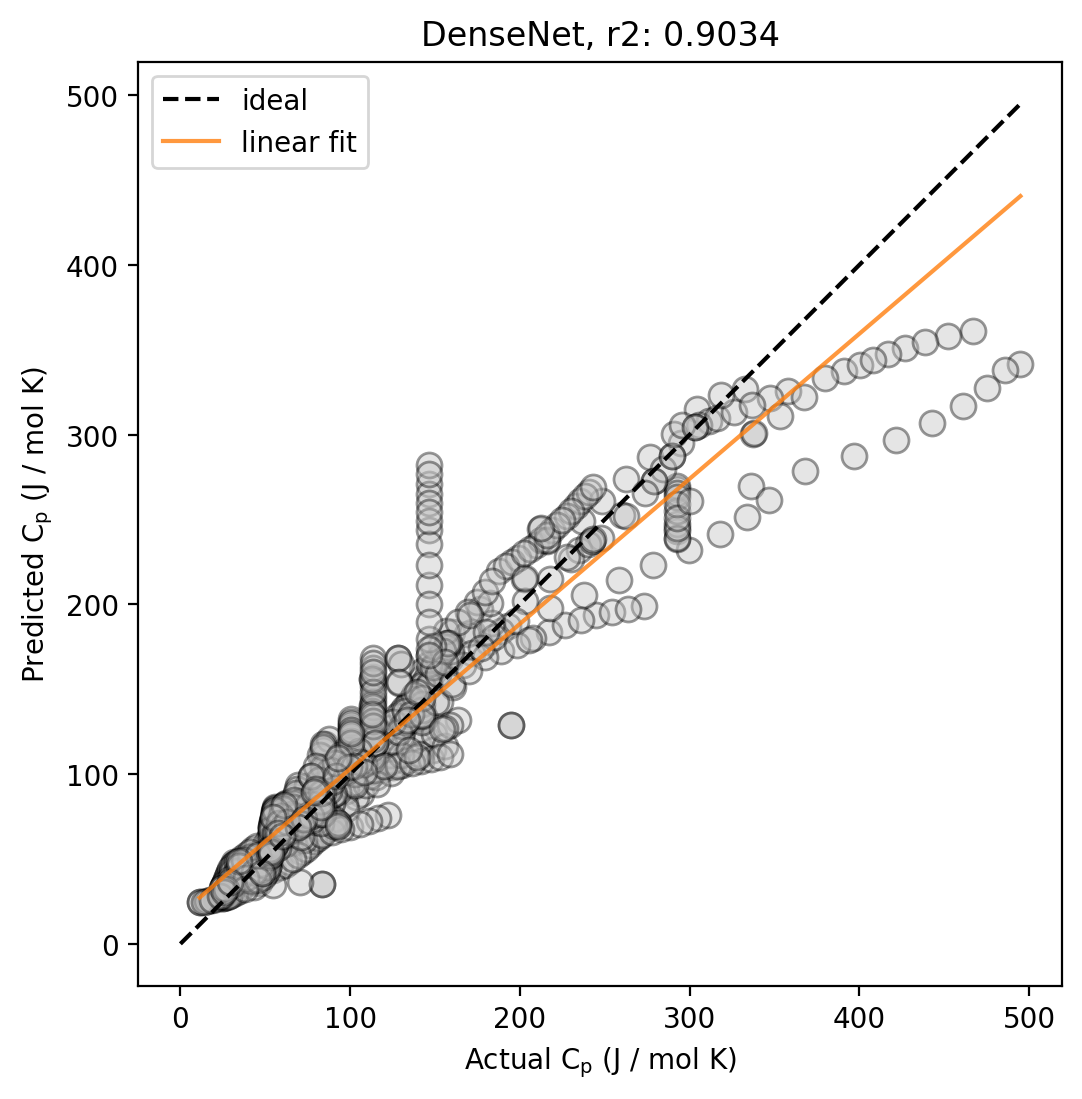

epoch: 220
epoch: 240


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: 0.9863
train mae: 3.2415
train rmse: 7.0992
val r2: 0.8938
val mae: 15.7891
val rmse: 26.1750


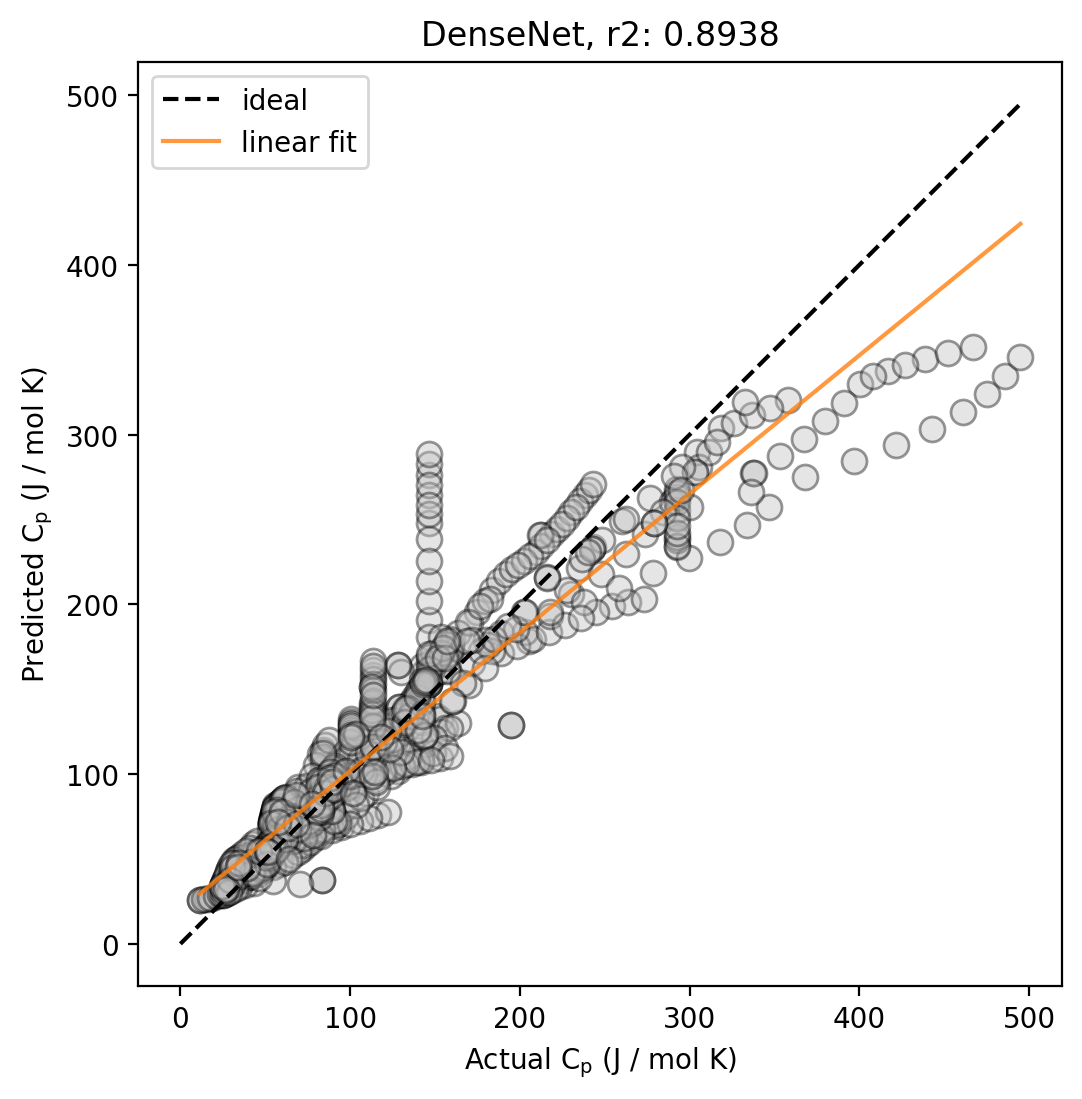

epoch: 260
epoch: 280
epoch: 300
train r2: 0.9872
train mae: 2.9077
train rmse: 6.8694
val r2: 0.8985
val mae: 15.2167
val rmse: 25.5800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


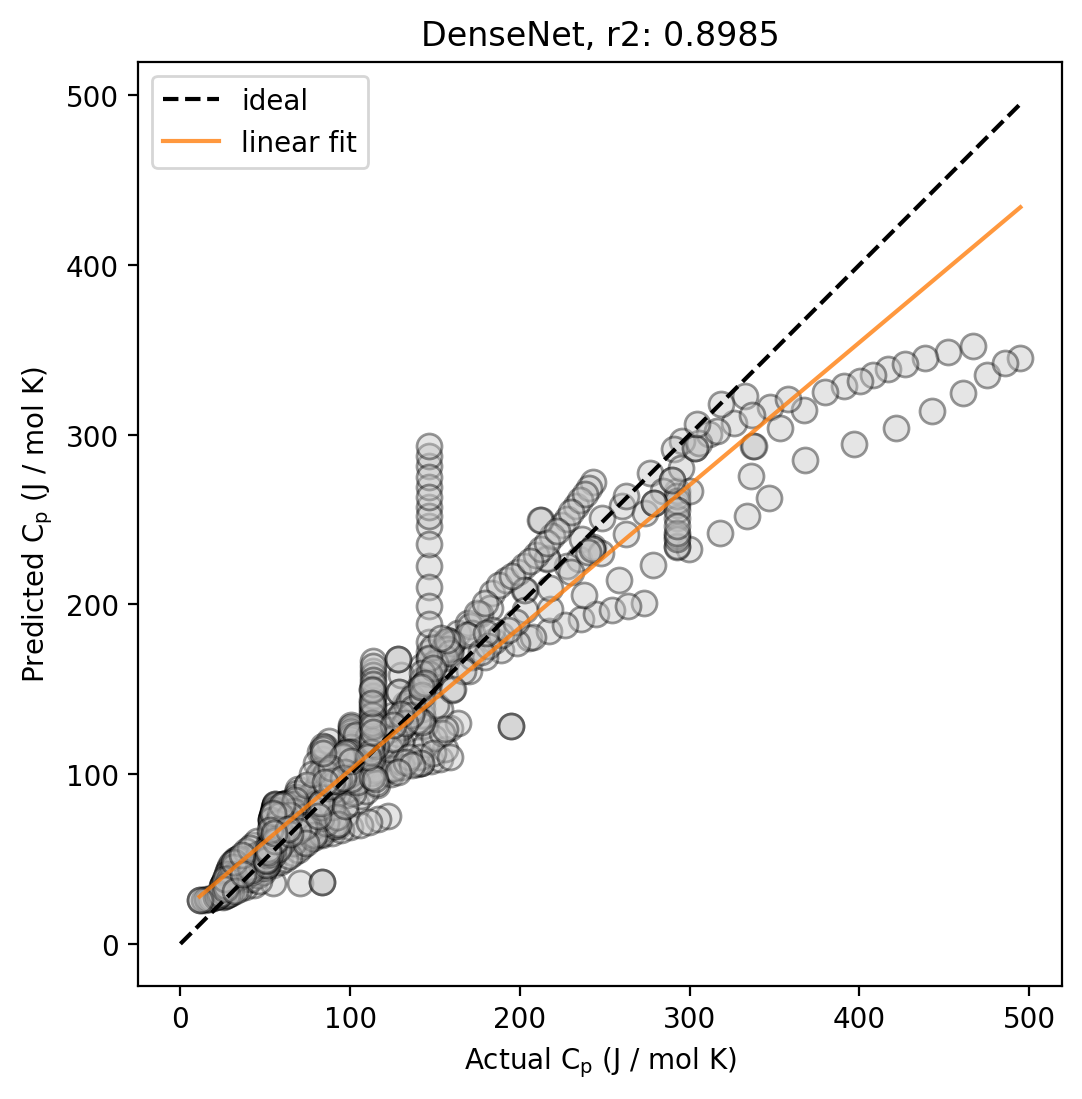

epoch: 320
epoch: 340


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: 0.9859
train mae: 3.4647
train rmse: 7.1912
val r2: 0.8958
val mae: 15.4210
val rmse: 25.9260


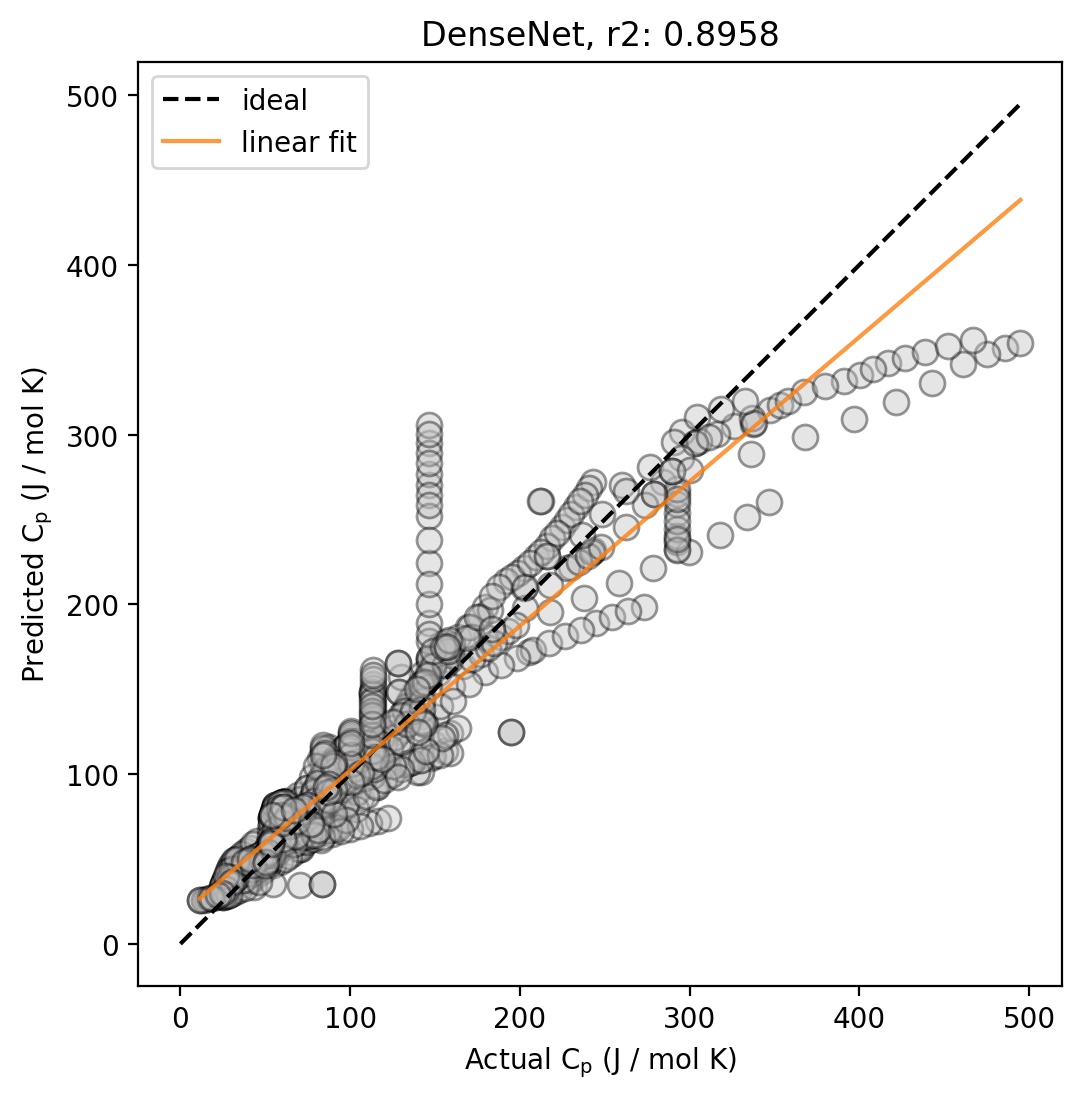

epoch: 360
epoch: 380
epoch: 400
train r2: 0.9860
train mae: 3.4794
train rmse: 7.1672
val r2: 0.8874
val mae: 16.1829
val rmse: 26.9440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


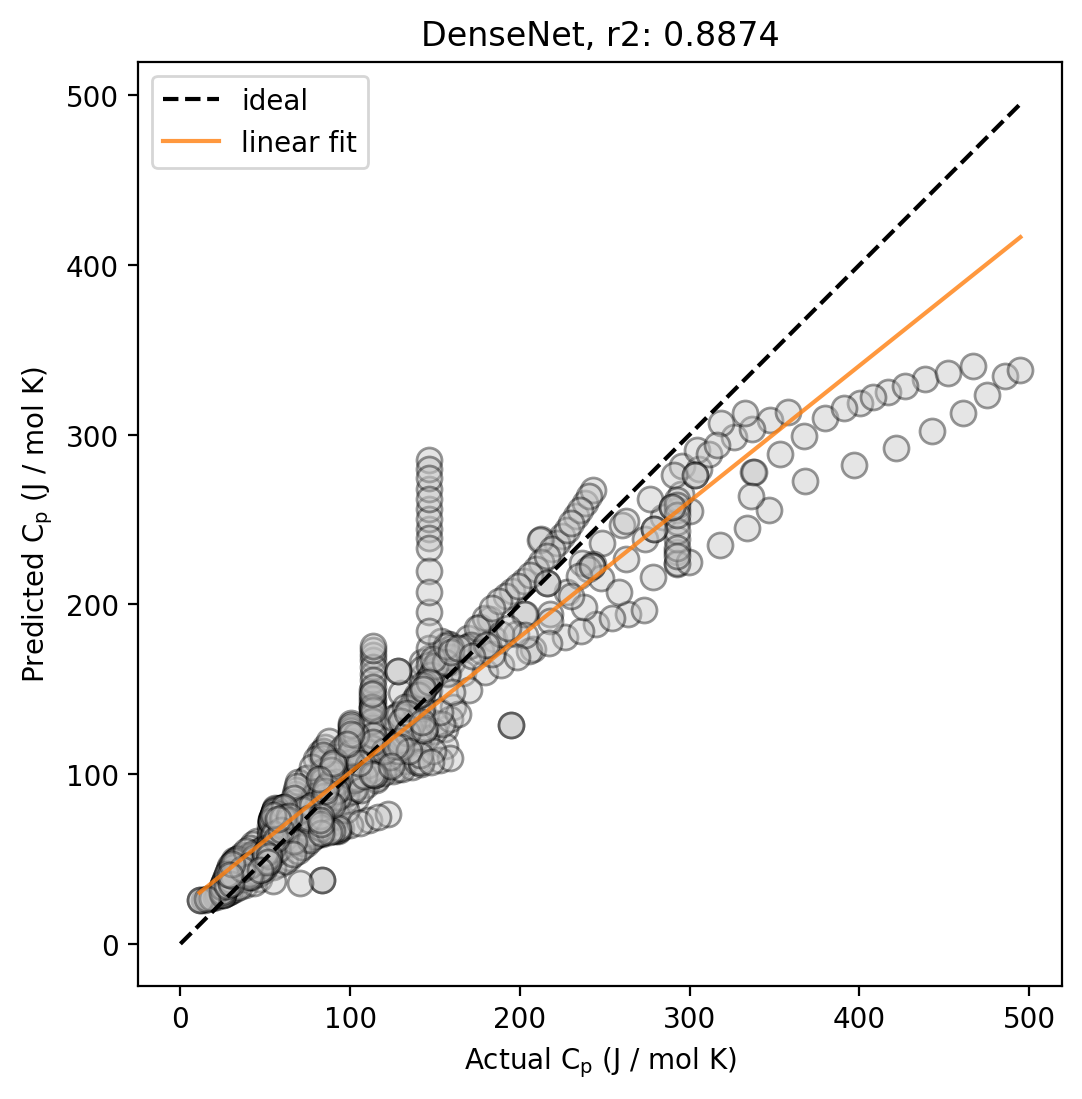

epoch: 420
epoch: 440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


train r2: 0.9866
train mae: 3.3955
train rmse: 7.0177
val r2: 0.8966
val mae: 15.1865
val rmse: 25.8202


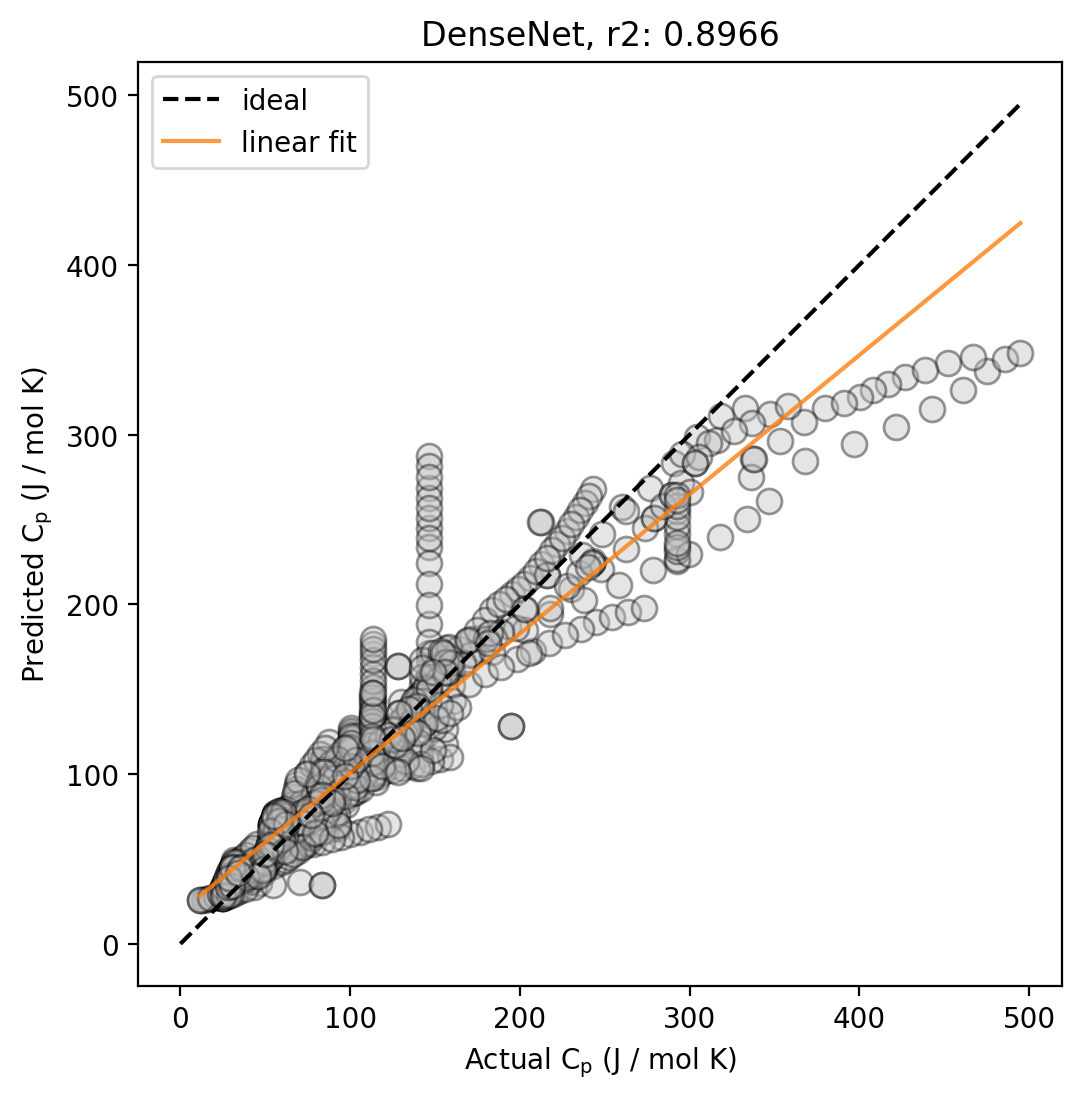

epoch: 460
epoch: 480
epoch: 499


In [146]:
data_type = torch.float
epochs = 500

print_every = 20
plot_every = 50

for epoch in range(epochs):
    if epoch % print_every == 0 or epoch == epochs - 1:
        print(f'epoch: {epoch}')
    if epoch % plot_every == 0:
        target_train, pred_train = predict(model, train_loader)
        train_scores = evaluate(target_train, pred_train)
        print_scores(train_scores, label='train')

        target_val, pred_val = predict(model, val_loader)
        val_scores = evaluate(target_val, pred_val)
        print_scores(val_scores, label='val')
        plot_pred_act(target_val, pred_val, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')
        plt.show()

    for i, data_output in enumerate(train_loader):
        X, y = data_output
        y = target_scaler.scale(y)

        X = X.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)
        y = y.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)

        optimizer.zero_grad()
        output = model.forward(X).flatten()
        loss = criterion(output.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

Now, with our trained neural network, we can evaluate the performance of the model (at the end of the training phase) on the validation dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


val r2: 0.9041
val mae: 14.8140
val rmse: 24.8681


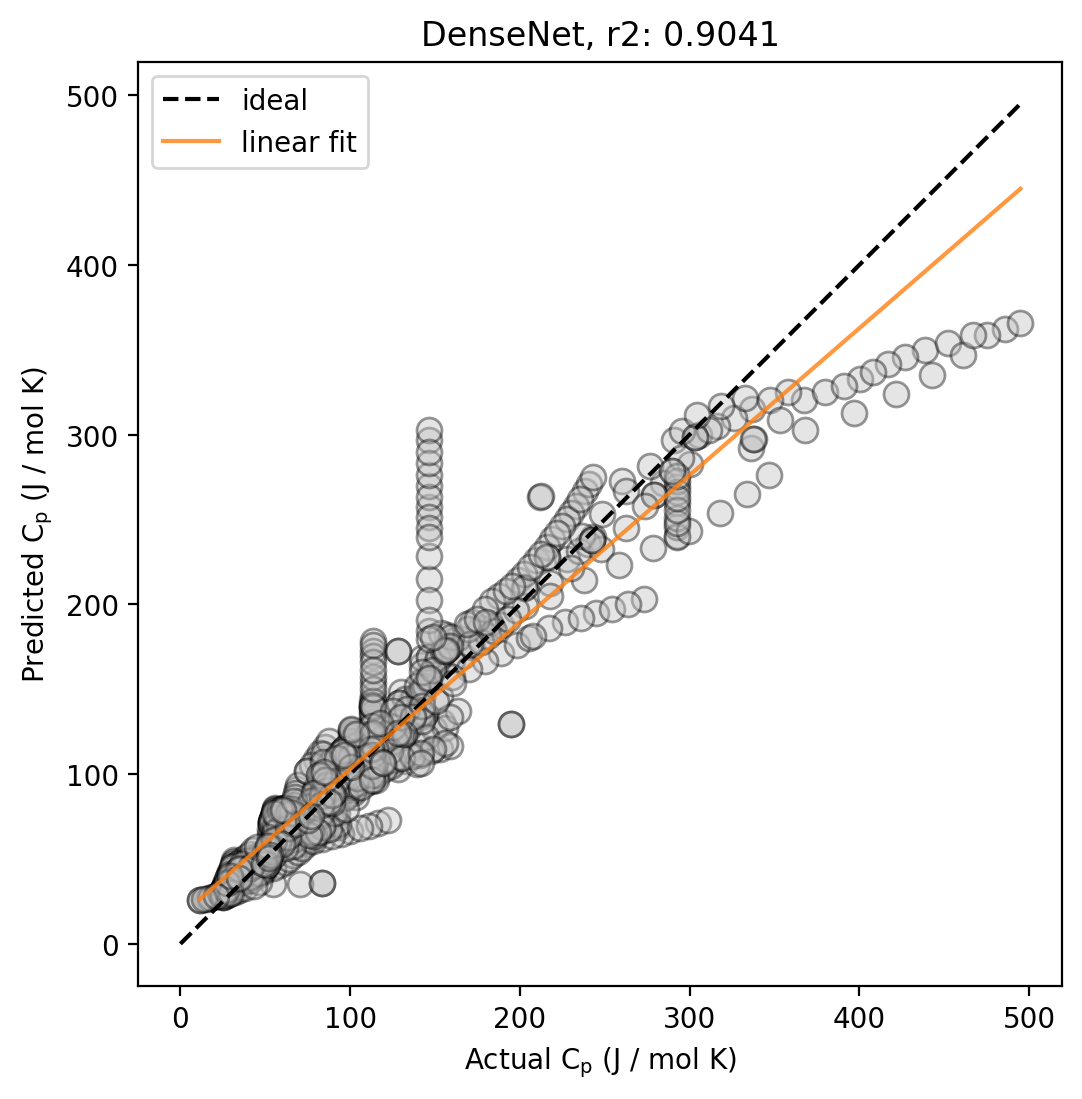

In [147]:
target_val, pred_val = predict(model, val_loader)
scores = evaluate(target_val, pred_val)

print_scores(scores, label='val')

plot = plot_pred_act(target_val, pred_val, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

## Keeping track of training progress -- avoid overfitting

Note, you can keep track of the training progress by saving the train and validation metrics such as $r^2$ and MAE at every epoch.
Then, you can plot so-called "loss curves" that show the loss of the model vs. epoch throughout the training process.
This gives you additional insight into your model training process, and helps you diagnose issues such as overfitting, improper model/optimizer/loss parameters, and so on.

Once you start tracking these performance metrics during your training loop, you can also implement more advanced training techniques such as "early stopping".
In early stopping, you observe the performance metrics (such as validation $r^2$ or MAE) over the training epochs, and you stop the training process if you observe that the metrics are not improving any more (meaning your model is fully trained), or if the metrics are increasing again after reaching a minimum (meaning your model is overfitting the training set).

## Evaluating model performance on test dataset

And finally evaluate the performance on the test dataset.
**Remember:** you should only do this *once!*

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


test r2: 0.8980
test mae: 15.1774
test rmse: 24.8970


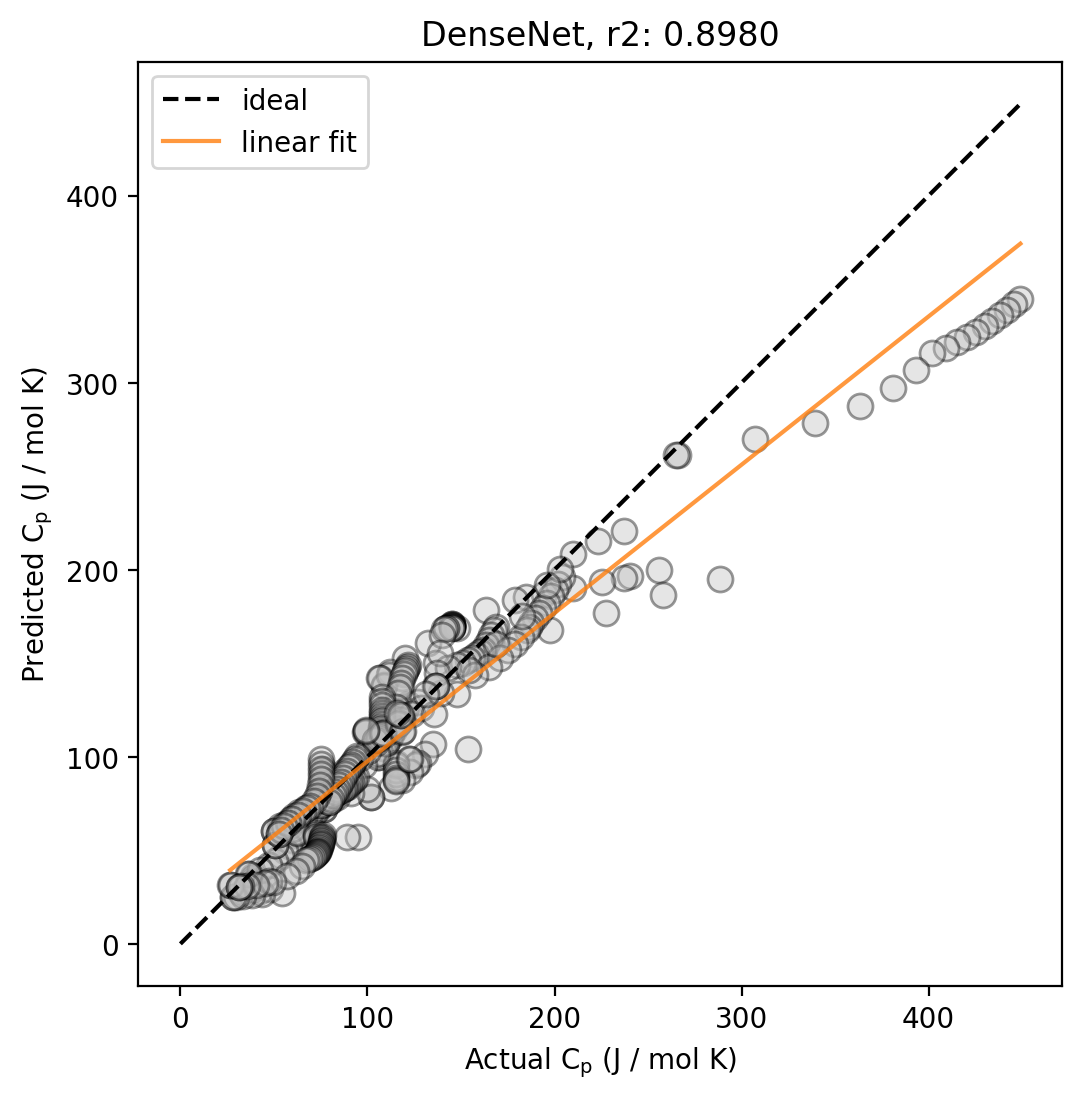

In [148]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

# Exporting PyTorch models

Now that we've got a (reasonably well-performing) model, we can export the weights and biases from the model to what is referred to as a "checkpoint" file.

The advantages of exporting your model to a checkpoint file are manifold.
For example, when you want to re-use the model again later (to make further predictions, or even to continue training), you don't have to train the model from scratch again.
For our current `DenseNet` model, this may not seem like a big deal, since it trains within minutes.
But once you start moving on to larger and larger models, model training time can reach hours, days---even weeks!

Another advantage is that you can greatly enhance the reproducibility of your work.
If you export your models, other researchers can then recreate your model architecture on their system, then load your weights into the model to get exactly the model you trained.
This allows them to use your model as-is, and enables them to reproduce your work---an important step if they are to judge the merit of your work.

With that said, we will now use PyTorch's built-in methods to export (1) our `DenseNet` model, and (2) our `target_scaler` (we need to export our `target_scaler` object as well, because we need to use it to unscale the model predictions to get back the true prediction values.

## Saving the model + target scaler

In [149]:
save_dict = {'weights': model.state_dict(),
             'scaler_state': target_scaler.state_dict()}
print(save_dict)

{'weights': OrderedDict([('network.0.0.weight', tensor([[ -0.0249,   0.0211,   0.1071,  ...,   0.4680,   0.3231,  -7.0035],
        [  1.2384,   1.3802,   0.6042,  ...,  -0.0138,  -0.3399,  -9.2210],
        [  0.4577,   0.4154,   0.7189,  ...,   0.2185,  -0.3207,   2.7633],
        ...,
        [ -0.5461,  -0.6354,  -0.2549,  ...,   0.8374,  -0.1677, -12.5038],
        [ -1.0038,  -1.0666,  -0.8132,  ...,  -0.1737,  -0.3497,  -4.3591],
        [  0.5815,   0.6558,   0.6949,  ...,  -0.5523,  -0.8544,  -5.7491]])), ('network.0.0.bias', tensor([-0.1812, -0.2383, -1.0439, -0.0702, -0.2336,  0.0957, -0.1741, -0.4390,
        -0.2887, -0.1443, -0.0364,  0.1152,  0.1435, -0.3363, -0.4565,  0.3595])), ('network.1.weight', tensor([[ 0.1265, -0.1828,  0.1662,  0.0780,  0.1976, -0.1727, -0.1290,  0.1443,
         -0.2110, -0.1266, -0.1775,  0.1602,  0.0790, -0.8003, -0.1897,  0.1623]])), ('network.1.bias', tensor([0.1751]))]), 'scaler_state': {'mean': tensor(4.5152, dtype=torch.float64), 'std': 

In [ ]:
pth_path = ('model_checkpoint.pth') # .pth is commonly used as the file extension
torch.save(save_dict, pth_path)

Navigate to your notebooks directory. You should now find a file named 'model_checkpoint.pth'.
Since the `DenseNet` model is small, the checkpoint file weighs in relatively lightly at 13KB.
Bigger models will have more weights & biases, and will require more storage space for the checkpoint file.

## Loading the model + target scaler

Of course, if you provide the facilities to **save** a model, you should also provide facilities to **load** them and to recreate your model back.

Thankfully, PyTorch makes this also easy.

In [150]:
# First, clear the variables for model and target_scaler.
# We want to start with a clean slate.
model = None
target_scaler = None
del model
del target_scaler

We start by recreating the `DenseNet` model and the `target_scaler` that we originally built. This model will be initialized with random weights & biases, which we will then overload (overwrite) afterwards with the values from the checkpoint file.

Make sure that you create the same model and `target_scaler` here as the ones you saved the checkpoint file from. Otherwise you will not be able to load the checkpoint file, or it will produce unexpected results.

In [151]:
# Instantiate the model.
# The model will be randomly initialized, but we will overwrite
# all weights and biases when we load the checkpoint.
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
model = model.to(compute_device)
print(model)

# Instantiate the target_scaler.
# We initialize this target_scaler with a vector of zeros,
# but we will overwrite its internal parameters
# when we load the checkpoint.
target_scaler = MeanLogNormScaler(torch.zeros(42))

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=309, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [ ]:
# Load the checkpoint and map it to the compute device
pth_path = ('model_checkpoint.pth')
checkpoint = torch.load(pth_path, map_location=compute_device)

# Load the state dictionaries back into the model and target_scaler
model.load_state_dict(checkpoint['weights'])
target_scaler.load_state_dict(checkpoint['scaler_state'])

## Checking the loaded model

In [152]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

ValueError: Input contains NaN.

Hooray!